## Análisis Exploratorio de Datos


Es menester recordar que el presente trabajo tiene un enfoque de análisis estratégico respecto a los datos de los establecimientos gastronómicos del Estado de California, con el objeto de obtener insights que permitan a los potenciales clientes de EPICUREAN Data Solutions contar con la información necesaria para tomar decisiones de índole empresarial, como ser, potenciales inversiones y oportunidades de crecimiento.
Para garantizar que se proporcionen datos pertinentes y útiles para la toma de esas decisiones estratégicas, es fundamental considerar el potencial y contundencia de los datos sobre los que se impulsará el proyecto.

En el presente documento, se detalla paso por paso los procedimientos realizados para llevar adelante el análisis propuesto, el que se vale fundamentalmente de metadatos de diferentes locales gastronómicos del Estado de California, y reseñas de diferentes usuarios sobre los mismos.

En el *procedimiento de ETL* se ha realizado la carga y corrección de datos, revisando los formatos, los valores nulos y valores faltantes. También se ha realizado una limpieza de cadenas de texto, corregido los formatos erróneos, y **manejado los valores duplicados**. Además, se ha hecho una inspección preliminar, para determinar qué datos podían ser de interés para este informe.

En esta nueva instancia, se procederá a un análisis de los datos seleccionadas por su relevancia, con mayor alcance que el análisis preliminar. Se intentará identificar patrones, outliers, comportamientos de los datos y su implicancia en el sector Gastronómico en el Estado de California.

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import re

#importamos las galerias necesarias

Procedemos a analizar, en primer lugar, la información disponible sobre locales gastronómicos del Estado de California.

In [2]:
df_metadatos = pd.read_parquet(r'C:\Users\GASTON\Desktop\PROYECTO FINAL\DATA\locales_google.parquet')
df_metadatos.head(3)

gmap_id          name  \
2    0x80c2c778e3b73d33:0xbdc58662a4a97d49  San Soo Dang   
6    0x80dd2b4c8555edb7:0xfc33d65c4bdbef42  Vons Chicken   
761   0x80c2baf50d29bf63:0x5bd904b842b9fcc   La Potranca   

                                               address   latitude   longitude  \
2    San Soo Dang, 761 S Vermont Ave, Los Angeles, ...  34.058092 -118.292130   
6    Vons Chicken, 12740 La Mirada Blvd, La Mirada,...  33.916402 -118.010855   
761  La Potranca, 12821 Venice Blvd., Los Angeles, ...  34.000181 -118.441249   

              category  avg_rating  num_of_reviews                 state  \
2    Korean restaurant         4.4              18     Open ⋅ Closes 6PM   
6           Restaurant         4.5              18  Open ⋅ Closes 9:30PM   
761         Restaurant         4.2              13   Closed ⋅ Opens 10AM   

                                      relative_results  \
2    0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2c...   
6                            Sin resultados vinculados   
761  0x80c2bac345536273:0x8b015c3512788465, 0x80c2c...   

                                       Service options clasificacion  \
2                           Takeout, Dine-in, Delivery  Dining Venue   
6    Outdoor seating, Curbside pickup, No-contact d...  Dining Venue   
761                                  Dine-in, Delivery  Dining Venue   

         address_depurada         city       county  
2       761 S Vermont Ave  Los Angeles  Los Angeles  
6    12740 La Mirada Blvd    La Mirada  Los Angeles  
761    12821 Venice Blvd.  Los Angeles  Los Angeles

In [7]:
df_metadatos.columns

Index(['gmap_id', 'name', 'address', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'state', 'relative_results',
       'Service options', 'clasificacion', 'address_depurada', 'city',
       'county'],
      dtype='object')

Comenzando con el análisis, observamos que cada establecimiento tiene su clave identificadora (gmap_id) que permite conectarse con las reseñas obtenidas (en la tabla 'reviews' que se analizará posteriormente).
En el proceso de ETL se ha extraído información de gran relevancia geográfica, ya que, sobre la base de su dirección, se extrajo la ciudad y se asignó su Condado.

In [13]:
ciudades = df_metadatos['city'].unique().size
condados = df_metadatos['county'].unique().size
print(f'El total de ciudades con establecimientos gastronómicos es de {ciudades}, mientras que la cantidad total de condados es {condados}')

El total de ciudades con establecimientos gastronómicos es de 683, mientras que la cantidad total de condados es 58


Para continuar analizando nuestra muestra representativa, podemos evaluar la cantidad de establecimientos calificados.

In [14]:
establecimientos = df_metadatos['gmap_id'].unique().size
print(f'La cantidad total de establecimientos con reseña en el Estado de California son {establecimientos}')

La cantidad total de establecimientos con reseña en el Estado de California son 7811


Procedemos, entonces, a correlacionar estas variables/categorias. Para ello, podemos sacar un ranking de los condados con más establecimientos calificados.

In [15]:
# Top 15 de condados con más establecimientos (conteo de gmap_id)
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Mostrar resultados
print("Top 15 condados con más establecimientos:")
print(top_15_condados)

Top 15 condados con más establecimientos:
            county  num_establecimientos
0            Acton                  1817
29          Orange                   736
36       San Diego                   550
18     Los Angeles                   496
1          Alameda                   397
42     Santa Clara                   382
37   San Francisco                   341
32       Riverside                   314
35  San Bernardino                   299
9           Fresno                   213
33      Sacramento                   212
6     Contra Costa                   185
55         Ventura                   158
40       San Mateo                   152
48          Sonoma                   139


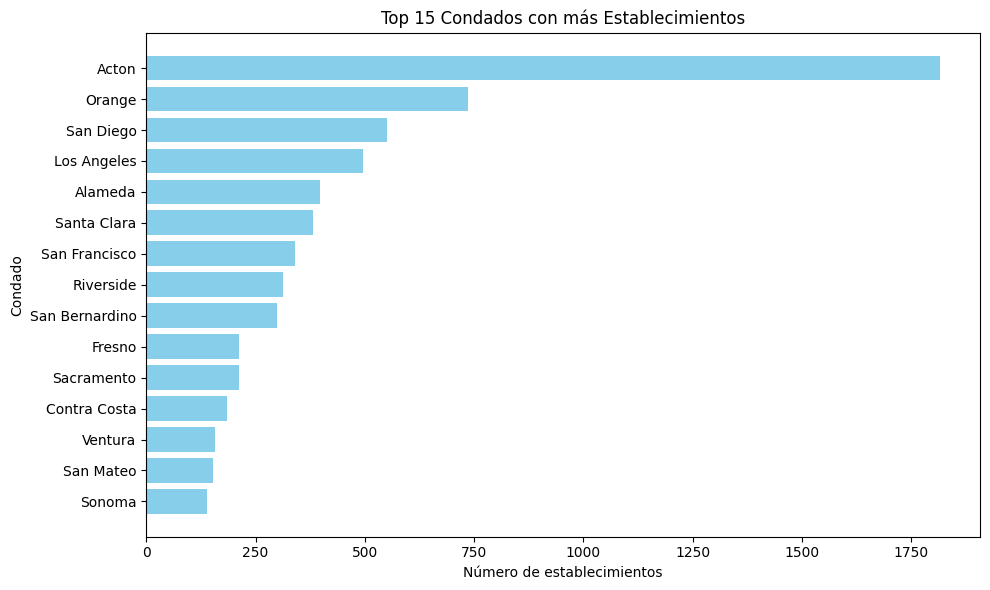

In [16]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.barh(top_15_condados['county'], top_15_condados['num_establecimientos'], color='skyblue')
plt.xlabel('Número de establecimientos')
plt.ylabel('Condado')
plt.title('Top 15 Condados con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje y para que el condado con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Veamos si hay cambios cuando realizamos el análisis por Ciudad, y no por condado.

In [18]:
# Top 15 de Ciudades con más establecimientos (conteo de gmap_id)
top_15_ciudades = df_metadatos.groupby('city')['gmap_id'].count().reset_index()
top_15_ciudades = top_15_ciudades.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_ciudades = top_15_ciudades.sort_values(by='num_establecimientos', ascending=False).head(15)


# Mostrar resultados
print("Top 15 Ciudades con más establecimientos:")
print(top_15_ciudades)

Top 15 Ciudades con más establecimientos:
              city  num_establecimientos
328    Los Angeles                   653
525  San Francisco                   341
522      San Diego                   244
528       San Jose                   176
208         Fresno                   139
513     Sacramento                   122
406        Oakland                   104
323     Long Beach                    90
543      Santa Ana                    90
35     Bakersfield                    79
499      Riverside                    73
14         Anaheim                    67
592       Stockton                    64
212   Garden Grove                    58
422         Oxnard                    55


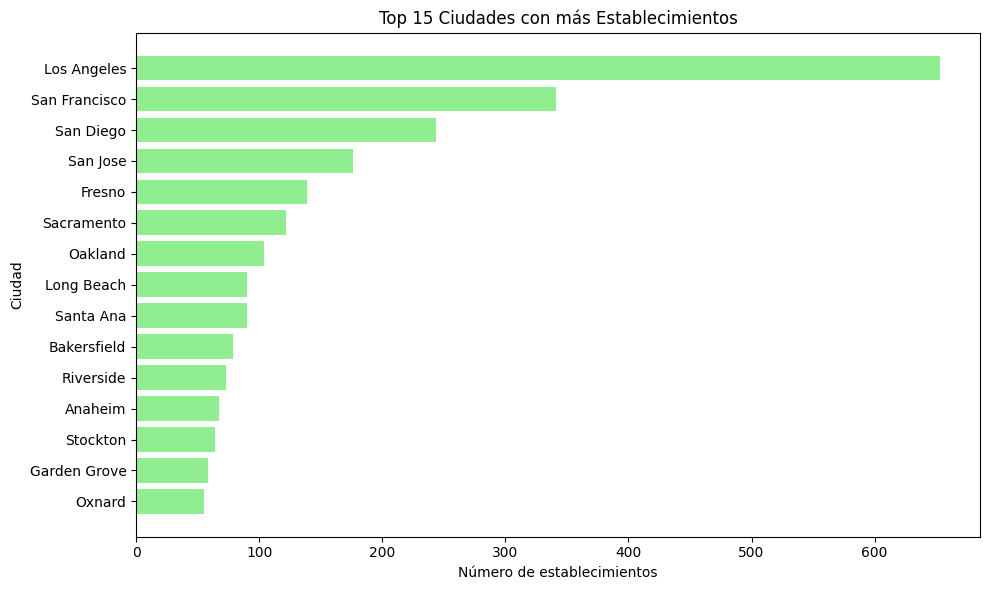

In [19]:
# Crear el histograma para el top 15 de ciudades con más establecimientos
plt.figure(figsize=(10, 6))
plt.barh(top_15_ciudades['city'], top_15_ciudades['num_establecimientos'], color='lightgreen')
plt.xlabel('Número de establecimientos')
plt.ylabel('Ciudad')
plt.title('Top 15 Ciudades con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje Y para que la ciudad con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Aquí hemos identificado que se encuentra erróneamente catalogado como "Acton" el Condado de Los Ángeles. Lo cambiaremos aquí, y se modifca el código para evitar este error en lo sucesivo en el proceso de ETL.

In [20]:
df_metadatos['county'] = df_metadatos['county'].replace('Acton', 'Los Angeles')

Ahora sí, podemos volver a realizar el análisis por Condados, para tener valores correctos

In [21]:
# Top 15 de condados con más establecimientos (conteo de gmap_id)
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Mostrar resultados
print("Top 15 condados con más establecimientos:")
print(top_15_condados)

Top 15 condados con más establecimientos:
            county  num_establecimientos
17     Los Angeles                  2313
28          Orange                   736
35       San Diego                   550
0          Alameda                   397
41     Santa Clara                   382
36   San Francisco                   341
31       Riverside                   314
34  San Bernardino                   299
8           Fresno                   213
32      Sacramento                   212
5     Contra Costa                   185
54         Ventura                   158
39       San Mateo                   152
47          Sonoma                   139
13            Kern                   137


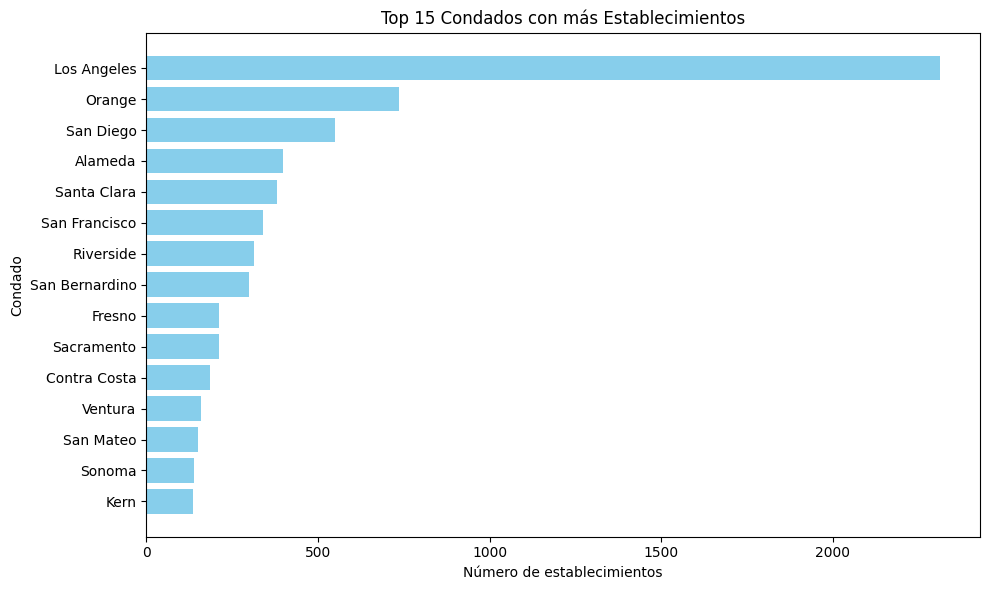

In [22]:
# Crear el histograma
plt.figure(figsize=(10, 6))
plt.barh(top_15_condados['county'], top_15_condados['num_establecimientos'], color='skyblue')
plt.xlabel('Número de establecimientos')
plt.ylabel('Condado')
plt.title('Top 15 Condados con más Establecimientos')
plt.gca().invert_yaxis()  # Invierte el eje y para que el condado con más establecimientos aparezca arriba
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los datos aquieren mucho más sentido: Los Angeles tienen un enorme atractivo turístico, sin dejar de ser una localidad ampliamente industrializada, con gran desarrollo comercial. Veamos ahora cuáles son las ciudades principales de esos condados.

In [23]:
# Obtener el top 15 de condados con más establecimientos
top_15_condados = df_metadatos.groupby('county')['gmap_id'].count().reset_index()
top_15_condados = top_15_condados.rename(columns={'gmap_id': 'num_establecimientos'})
top_15_condados = top_15_condados.sort_values(by='num_establecimientos', ascending=False).head(15)

# Crear un DataFrame para almacenar los resultados
resultados_top_ciudades = []

# Iterar sobre cada condado en el top 15
for condado in top_15_condados['county']:
    # Filtrar por el condado actual
    ciudades_en_condado = df_metadatos[df_metadatos['county'] == condado]
    
    # Obtener el top 3 de ciudades con más establecimientos
    top_ciudades = ciudades_en_condado.groupby('city')['gmap_id'].count().reset_index()
    top_ciudades = top_ciudades.rename(columns={'gmap_id': 'num_establecimientos'})
    top_ciudades = top_ciudades.sort_values(by='num_establecimientos', ascending=False).head(3)
    
    # Añadir el condado como columna en el resultado
    top_ciudades['county'] = condado
    
    # Agregar al resultado
    resultados_top_ciudades.append(top_ciudades)

# Concatenar todos los resultados en un solo DataFrame
df_resultados = pd.concat(resultados_top_ciudades, ignore_index=True)

# Mostrar resultados
print(df_resultados)

                city  num_establecimientos          county
0        Los Angeles                   653     Los Angeles
1         Long Beach                    90     Los Angeles
2           Glendale                    45     Los Angeles
3          Santa Ana                    90          Orange
4            Anaheim                    67          Orange
5       Garden Grove                    58          Orange
6          San Diego                   244       San Diego
7        Chula Vista                    40       San Diego
8           El Cajon                    25       San Diego
9            Oakland                   104         Alameda
10          Berkeley                    46         Alameda
11           Fremont                    45         Alameda
12          San Jose                   176     Santa Clara
13       Santa Clara                    32     Santa Clara
14         Sunnyvale                    27     Santa Clara
15     San Francisco                   341   San Francis

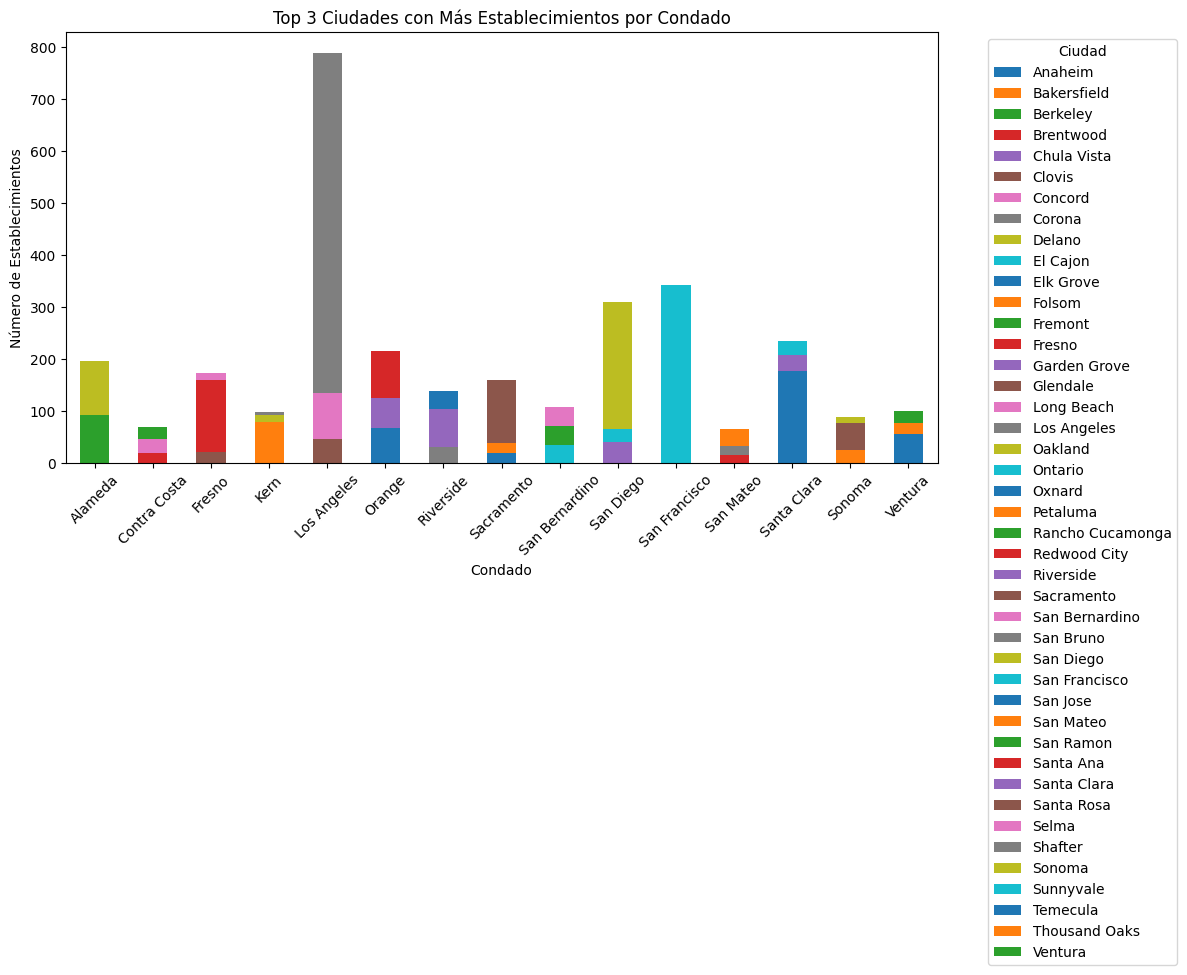

In [24]:
# Crear un DataFrame para las ciudades en formato adecuado para gráfico
df_resultados_pivot = df_resultados.pivot(index='county', columns='city', values='num_establecimientos').fillna(0)

# Crear el gráfico de columnas apiladas
plt.figure(figsize=(12, 8))
df_resultados_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), color=plt.cm.tab10.colors)

plt.title('Top 3 Ciudades con Más Establecimientos por Condado')
plt.xlabel('Condado')
plt.ylabel('Número de Establecimientos')
plt.xticks(rotation=45)
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

La distribución por ciudades, condados y la cantidad de establecimientos sirve para detectar algunos indicadores, a primera vista, dignos de ser analizados:

- Densidad Poblacional: Un mayor número de establecimientos suele correlacionarse con una población más densa, lo que significa que hay más consumidores disponibles para los negocios.

- Actividad Económica: Una alta concentración de establecimientos puede reflejar una economía local activa, con diversas oportunidades comerciales y una buena infraestructura de servicios.

- Atracción Turística: Ciudades o condados con un gran número de establecimientos, especialmente en el sector de servicios, pueden ser destinos turísticos importantes, ofreciendo restaurantes, tiendas, hoteles y actividades recreativas.

- Acceso a Recursos y Servicios: Un mayor número de establecimientos puede indicar un mejor acceso a bienes y servicios para los residentes, lo que puede mejorar la calidad de vida.

- Competencia y Diversidad: Un alto número de negocios en una área también sugiere un mercado competitivo, lo que puede beneficiar a los consumidores a través de precios más bajos y una mayor diversidad de opciones.

- Inversión y Desarrollo: Un crecimiento en el número de establecimientos puede ser indicativo de inversión en la infraestructura local y desarrollo urbano, lo que puede ser positivo para la economía de la región. 

# Categorías de los Establecimientos

Corresponde adentrarnos en el análisis de las diferentes categorías, y luego podremos realizar un análisis cruzada para obtener mejores conclusiones.

In [26]:
cant_categorias = df_metadatos['category'].unique().size
print(f'La muestra representativa presenta un total de {cant_categorias} categorías diferentes')

La muestra representativa presenta un total de 2212 categorías diferentes


In [31]:
categorias = df_metadatos['category'].unique()
categorias

array(['Korean restaurant', 'Restaurant',
       'Convenience store, ATM, Coffee shop, Coffee store, Public bathroom, Snack bar, Soft drinks shop',
       ...,
       'Pizza takeaway, American restaurant, Italian restaurant, Pizza restaurant, Vegetarian restaurant',
       'Bagel shop, Coffee shop',
       'American restaurant, Brunch restaurant, Cocktail bar, Restaurant'],
      dtype=object)

Tenemos más de 2000 categorías, lo que hace difícil un análisis a secas.

In [32]:
# Contar el número de locales por categoría usando gmap_id
conteo_categorias = df_metadatos.groupby('category')['gmap_id'].count().reset_index()

# Renombrar las columnas para mayor claridad
conteo_categorias.columns = ['category', 'num_locales']

# Ordenar las categorías por el número de locales en orden descendente
conteo_categorias = conteo_categorias.sort_values(by='num_locales', ascending=False)

# Mostrar las categorías ordenadas
print(conteo_categorias)

                                               category  num_locales
1685                                         Restaurant          948
1332                                 Mexican restaurant          553
1930  Sandwich shop, Caterer, Fast food restaurant, ...          348
112                                              Bakery          274
333                                                Cafe          235
...                                                 ...          ...
781   Ecuadorian restaurant, Bar, Family restaurant,...            1
780   Eclectic restaurant, Caterer, Deli, Restaurant...            1
779                             East African restaurant            1
778   Dumpling restaurant, Chinese restaurant, Chine...            1
2211  Wok restaurant, Asian fusion restaurant, Asian...            1

[2212 rows x 2 columns]


Analicemos las categorías principales, con más número de locales.

In [33]:
# Obtener el top 20 de categorías
top_20_categorias = conteo_categorias.head(20)

# Mostrar el top 20 de categorías
print(top_20_categorias)

                                               category  num_locales
1685                                         Restaurant          948
1332                                 Mexican restaurant          553
1930  Sandwich shop, Caterer, Fast food restaurant, ...          348
112                                              Bakery          274
333                                                Cafe          235
568                                         Coffee shop          197
500                                  Chinese restaurant          171
1572                                   Pizza restaurant          123
2164                              Vietnamese restaurant           79
2066                                    Taco restaurant           76
592   Coffee shop, Breakfast restaurant, Cafe, Coffe...           74
1168                                Japanese restaurant           69
1950                                 Seafood restaurant           64
606       Coffee shop, Cafe, Coffe

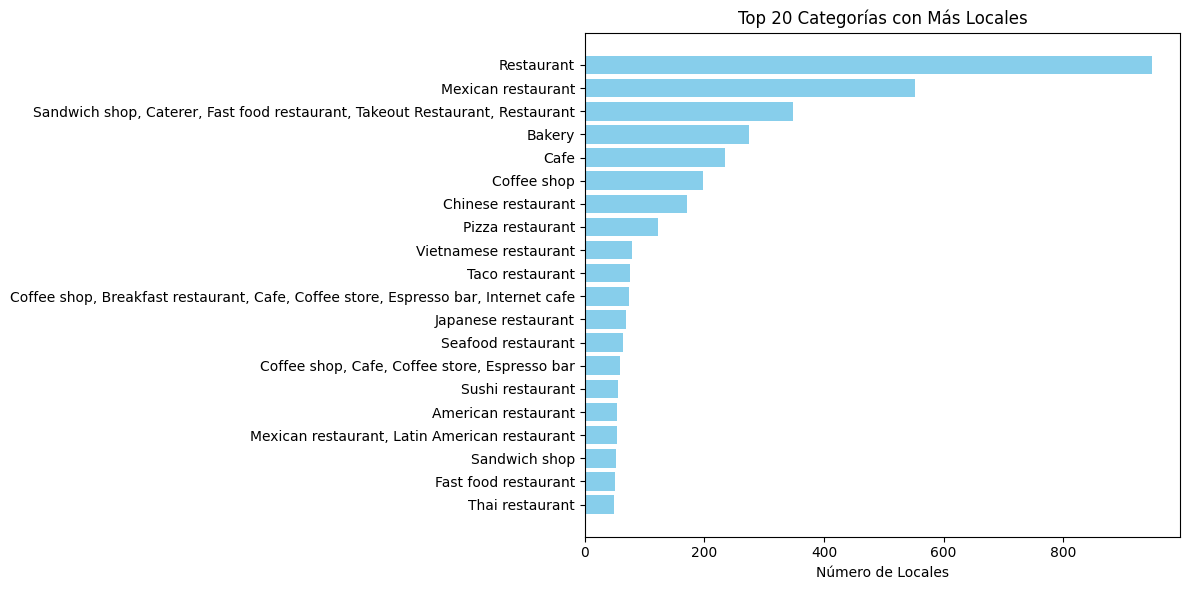

In [34]:
import matplotlib.pyplot as plt

# Crear el histograma
plt.figure(figsize=(12, 6))
plt.barh(top_20_categorias['category'], top_20_categorias['num_locales'], color='skyblue')
plt.xlabel('Número de Locales')
plt.title('Top 20 Categorías con Más Locales')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la categoría con más locales en la parte superior
plt.tight_layout()

# Mostrar el gráfico
plt.show()


La categoría principal es 'Restaurant', y da cuenta de un establecimiento con servicio de atención en el local, aunque no exclusivamente. Veamos hora las palabras que más se repiten dentro de estos establecimientos.

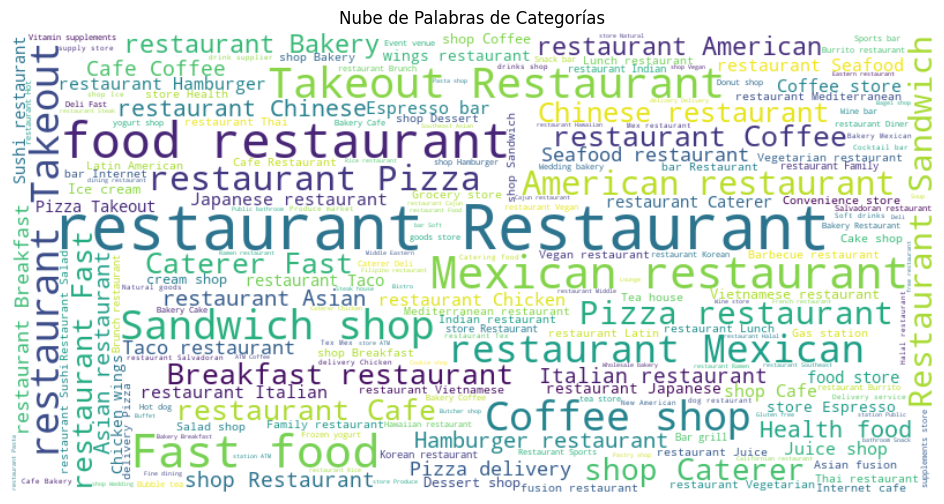

In [36]:
# Unir todas las categorías en un solo string
text = ' '.join(df_metadatos['category'].astype(str))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras de Categorías')
plt.show()


Se pueden analizar en profundidad los servicios que se indican en la categoría del establecimiento.

In [38]:
# Lista de palabras clave para filtrar
palabras_clave = ['restaurant', 'delivery', 'takeout', 'pickup']

# Filtrar las categorías que contienen alguna de las palabras clave (sin distinción entre mayúsculas y minúsculas)
filtro_categorias = df_metadatos['category'].str.contains('|'.join(palabras_clave), case=False)

# Contar el número de categorías filtradas
conteo_categorias_filtradas = df_metadatos[filtro_categorias]['category'].nunique()

# Mostrar el conteo
print(f"De todos los registros, un total de {conteo_categorias_filtradas} indican el servicio.")


De todos los registros, un total de 1864 indican el servicio.


In [40]:
# Inicializar un diccionario para contar las apariciones de cada palabra clave
conteo_palabras = {palabra: 0 for palabra in palabras_clave}

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Contar las apariciones de cada palabra clave en las categorías
for palabra in palabras_clave:
    conteo_palabras[palabra] = categorias_bajas.str.count(palabra).sum()

# Mostrar los resultados
for palabra, conteo in conteo_palabras.items():
    print(f"La palabra '{palabra}' aparece {conteo} veces en las categorías.")


La palabra 'restaurant' aparece 11881 veces en las categorías.
La palabra 'delivery' aparece 451 veces en las categorías.
La palabra 'takeout' aparece 973 veces en las categorías.
La palabra 'pickup' aparece 0 veces en las categorías.


In [41]:
# Inicializar un diccionario para contar los registros por palabra clave
conteo_registros = {palabra: 0 for palabra in palabras_clave}

# Contar registros donde cada palabra clave aparece al menos una vez
for palabra in palabras_clave:
    conteo_registros[palabra] = categorias_bajas.str.contains(palabra).sum()

# Mostrar los resultados
for palabra, conteo in conteo_registros.items():
    print(f"La palabra '{palabra}' aparece en {conteo} registros de categorías.")


La palabra 'restaurant' aparece en 6379 registros de categorías.
La palabra 'delivery' aparece en 391 registros de categorías.
La palabra 'takeout' aparece en 919 registros de categorías.
La palabra 'pickup' aparece en 0 registros de categorías.


Ahora realizaremos ese análisis, respecto a los tipos de comida ofrecidos

In [42]:
# Definir los grupos de palabras clave
grupos_palabras = {
    'cafe_coffee_espresso': ['cafe', 'coffee', 'espresso'],
    'pizza': ['pizza'],
    'japanese': ['japanese'],
    'sandwich': ['sandwich'],
    'taco_mexican': ['taco', 'mexican'],
    'indian': ['indian'],
    'chinese': ['chinese'],
    'vegetarian': ['vegetarian'],
    'chicken': ['chicken'],
    'burger_hamburger': ['burger', 'hamburger'],
    'salad': ['salad'],
    'soup': ['soup'],
    'dessert': ['dessert']
}

# Inicializar un diccionario para contar los registros por grupo de palabras clave
conteo_registros_grupos = {grupo: 0 for grupo in grupos_palabras.keys()}

# Convertir la columna 'category' a minúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Contar registros donde cada grupo de palabras aparece al menos una vez
for grupo, palabras in grupos_palabras.items():
    # Crear un patrón para la búsqueda
    patron = '|'.join(palabras)
    conteo_registros_grupos[grupo] = categorias_bajas.str.contains(patron).sum()

# Mostrar los resultados
for grupo, conteo in conteo_registros_grupos.items():
    print(f"El grupo '{grupo}' aparece en {conteo} registros de categorías.")


El grupo 'cafe_coffee_espresso' aparece en 1251 registros de categorías.
El grupo 'pizza' aparece en 551 registros de categorías.
El grupo 'japanese' aparece en 187 registros de categorías.
El grupo 'sandwich' aparece en 771 registros de categorías.
El grupo 'taco_mexican' aparece en 1057 registros de categorías.
El grupo 'indian' aparece en 87 registros de categorías.
El grupo 'chinese' aparece en 351 registros de categorías.
El grupo 'vegetarian' aparece en 137 registros de categorías.
El grupo 'chicken' aparece en 268 registros de categorías.
El grupo 'burger_hamburger' aparece en 255 registros de categorías.
El grupo 'salad' aparece en 112 registros de categorías.
El grupo 'soup' aparece en 40 registros de categorías.
El grupo 'dessert' aparece en 174 registros de categorías.


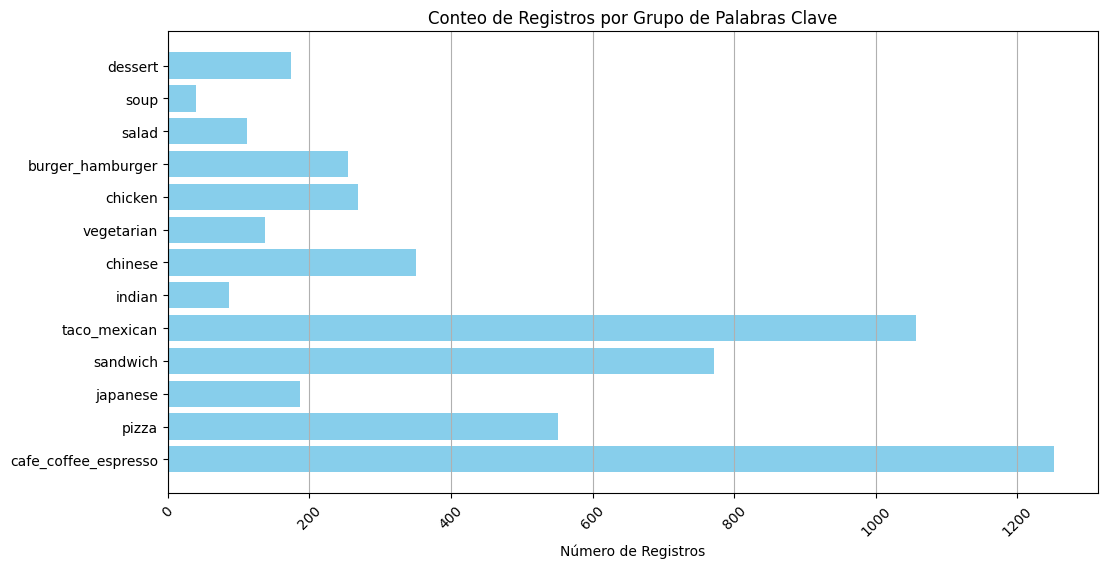

In [43]:
import matplotlib.pyplot as plt

# Crear listas para los nombres de los grupos y sus conteos
grupos = list(conteo_registros_grupos.keys())
conteos = list(conteo_registros_grupos.values())

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(grupos, conteos, color='skyblue')
plt.xlabel('Número de Registros')
plt.title('Conteo de Registros por Grupo de Palabras Clave')
plt.xticks(rotation=45)
plt.grid(axis='x')

# Mostrar el gráfico
plt.show()


Observemos si hay primacía de alguna ciudad sobre las preferencias.

In [44]:
# Inicializar un diccionario para almacenar los resultados
top_ciudades_por_grupo = {grupo: {} for grupo in grupos_palabras.keys()}

# Contar las ciudades para cada grupo de palabras clave
for grupo, palabras in grupos_palabras.items():
    patron = '|'.join(palabras)
    # Filtrar las ciudades que contienen alguna de las palabras del grupo
    ciudades_con_palabra = df_metadatos[categorias_bajas.str.contains(patron)]['city']
    # Contar las ocurrencias de cada ciudad
    conteo_ciudades = ciudades_con_palabra.value_counts().head(3)
    top_ciudades_por_grupo[grupo] = conteo_ciudades

# Mostrar los resultados
for grupo, conteo in top_ciudades_por_grupo.items():
    print(f"\nTop 3 ciudades para el grupo '{grupo}':")
    print(conteo)



Top 3 ciudades para el grupo 'cafe_coffee_espresso':
city
Los Angeles      90
San Francisco    88
San Diego        42
Name: count, dtype: int64

Top 3 ciudades para el grupo 'pizza':
city
Los Angeles    35
San Diego      12
Sacramento     12
Name: count, dtype: int64

Top 3 ciudades para el grupo 'japanese':
city
Los Angeles      18
San Francisco     8
Torrance          7
Name: count, dtype: int64

Top 3 ciudades para el grupo 'sandwich':
city
Los Angeles      39
San Diego        28
San Francisco    28
Name: count, dtype: int64

Top 3 ciudades para el grupo 'taco_mexican':
city
Los Angeles    99
Fresno         34
Santa Ana      26
Name: count, dtype: int64

Top 3 ciudades para el grupo 'indian':
city
Los Angeles      6
Sacramento       5
San Francisco    5
Name: count, dtype: int64

Top 3 ciudades para el grupo 'chinese':
city
Los Angeles    34
San Diego      13
San Jose       11
Name: count, dtype: int64

Top 3 ciudades para el grupo 'vegetarian':
city
Los Angeles      14
San Diego  

In [47]:
# Inicializar un diccionario para almacenar las preferencias por ciudad
preferencias_por_ciudad = {}

# Iterar sobre cada fila en el DataFrame de resultados
for _, fila in df_resultados.iterrows():
    ciudad = fila['city']
    condado = fila['county']
    
    # Filtrar las categorías de la ciudad
    categorias_ciudad = df_metadatos[df_metadatos['city'] == ciudad]['category']
    
    # Contar las palabras clave presentes en las categorías
    conteo_palabras = {}
    for grupo, palabras in grupos_palabras.items():
        patron = '|'.join(palabras)
        conteo_palabras[grupo] = categorias_ciudad.str.contains(patron, case=False, na=False).sum()
    
    # Almacenar el conteo de palabras en el diccionario de preferencias
    preferencias_por_ciudad[ciudad] = conteo_palabras

# Mostrar las preferencias por ciudad
for ciudad, conteo in preferencias_por_ciudad.items():
    print(f"\nPreferencias para la ciudad '{ciudad}':")
    for grupo, cantidad in conteo.items():
        print(f"  - {grupo}: {cantidad}")



Preferencias para la ciudad 'Los Angeles':
  - cafe_coffee_espresso: 90
  - pizza: 35
  - japanese: 18
  - sandwich: 39
  - taco_mexican: 99
  - indian: 6
  - chinese: 34
  - vegetarian: 14
  - chicken: 23
  - burger_hamburger: 20
  - salad: 16
  - soup: 5
  - dessert: 12

Preferencias para la ciudad 'Long Beach':
  - cafe_coffee_espresso: 12
  - pizza: 9
  - japanese: 1
  - sandwich: 9
  - taco_mexican: 13
  - indian: 0
  - chinese: 1
  - vegetarian: 0
  - chicken: 9
  - burger_hamburger: 2
  - salad: 2
  - soup: 0
  - dessert: 0

Preferencias para la ciudad 'Glendale':
  - cafe_coffee_espresso: 9
  - pizza: 8
  - japanese: 2
  - sandwich: 5
  - taco_mexican: 0
  - indian: 0
  - chinese: 0
  - vegetarian: 2
  - chicken: 2
  - burger_hamburger: 2
  - salad: 1
  - soup: 0
  - dessert: 1

Preferencias para la ciudad 'Santa Ana':
  - cafe_coffee_espresso: 13
  - pizza: 2
  - japanese: 1
  - sandwich: 6
  - taco_mexican: 26
  - indian: 0
  - chinese: 2
  - vegetarian: 0
  - chicken: 4
  -

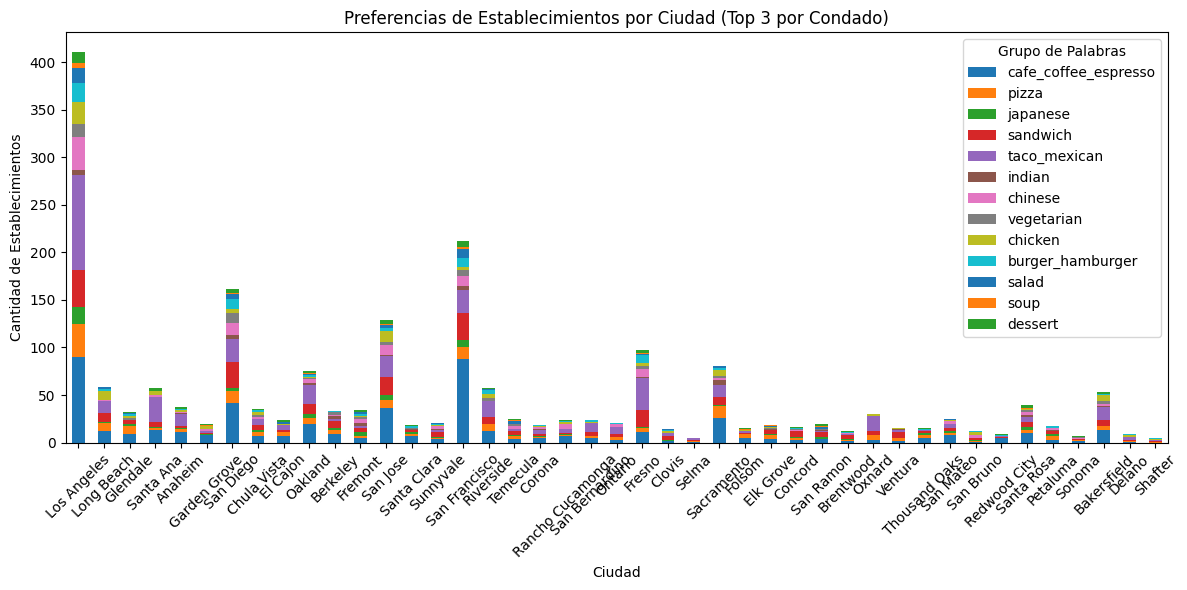

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el diccionario de preferencias a un DataFrame
preferencias_df = pd.DataFrame(preferencias_por_ciudad).T

# Resetear el índice para tener las ciudades como una columna
preferencias_df.reset_index(inplace=True)
preferencias_df.rename(columns={'index': 'city'}, inplace=True)

# Crear un gráfico de barras para cada grupo de palabras
preferencias_df.set_index('city').plot(kind='bar', stacked=True, figsize=(12, 6))

# Personalizar el gráfico
plt.title('Preferencias de Establecimientos por Ciudad (Top 3 por Condado)')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad de Establecimientos')
plt.legend(title='Grupo de Palabras')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Los informes anteriores me traen a este gráfico, en el que podemos visualizar las preferencias de cada una de las principales ciudades por condados. Estas preferencias permiten identificar ciertas tendencias en el consumo.
Podemos ver, a primera vista, que ciertas ciudades como Los Angeles, San Franciso o Santa Clara tienen una gran cantidad de establecimientos con 'ensaladas' (salad) o 'sopas' (soup): aparentemente, en esas ciudades puede haber un gran mercado dispuesto al consumo saludable. También es alta la cantidad de locales de 'sandwichs' y 'café', lo que implica un consumo habitual de los mismos en centros urbanos o industriales.
La presencia de múltiples establecimientos en una categoría específica puede indicar un mercado competitivo, lo que a su vez puede beneficiar a los consumidores con mejores precios y servicios.
Identificar las preferencias menos satisfechas o las categorías en crecimiento puede ofrecer oportunidades para nuevos negocios. 
En ciudades con alta afluencia turística, las categorías populares pueden estar alineadas con las expectativas de los visitantes, lo que puede influir en el tipo de establecimientos que se establecen.

## Identificación de zonas de interés

Ya hemos visto los condados y locales con más establecimientos comerciales. Ciertamente, la media aritmética funciona como indicador: hay zonas que no tienen una cantidad de establecimientos suficientes para hablar de una zona comercial gastronómica establecida. 
El establecimiento de zonas inéditas implica un riesgo mayor en la inversión. No es una posibilidad tan remota: se pueden identificar tendencias crecientes y confrontar con la cantidad de establecimientos disponibles. No obstante, tales oportunidades escapan el marco del presente análisis:
***Este proyecto tiene como cliente objetivo empresarios o emprendedores que buscan inversiones con un riesgo moderado***. Por ello, el punto de partida es un mercado establecido con una población medianamente grande, para reducir los riesgos y garantizar un retorno de inversión mínimo.

En ese sentido, hemos de analizar geo-económicamente al Estado de California.

Si bien hay [varios informes económicos disponibles](https://es.wikipedia.org/wiki/Econom%C3%ADa_de_California), lo cierto es que en la mayoría de ellos se destaca a Estado de California como una de las economías más grandes del Mundo. De hecho, es habitual la comparación con diferentes países, en donde generalmente prevalece el Estado del suroeste norteamericano.
En búsqueda de la explicación de esta economía tan firme y consolidada, aparecen tres factores:
- Instalación y crecimiento de grandes polos tecnológicos: en el Estado de California, principalmente en Silicon Valley, se han instalado muchas empresas dedicadas a la tecnología, comunicaciones y ciencias de la computación. Esta red de empresas, seducida por programas de apoyo y beneficios impositivos, tiene una gran incidencia en la alta tasa de empleo y educación, que tiene un impacto directo en la economía regional.
- Diversidad en la oferta turística: el Estado de California cuenta con una serie de atractivos que abarcan playas, viñedos, zoológicos, parques naturales, montañas, y más. Estas atracciones, sumado a clima mediterráneo, caracterizado por veranos cálidos y secos e inviernos suaves y lluviosos, garantizan un movimiento de turistas constante, que impulsa las economías locales.
- Decisión de explotar ambos potenciales: por lo general, un Estado define la economía regional en una disputa Industria vs. Turismo. Esta tendencia se ha repetido acabadamente en muchos puntos del planeta, donde grandes espacios geográficos deben optar por una de las dos alternativas. En el caso de california, ha contribuido mucho que las empresas intenten ser cada vez más "verdes" y que, en general, se ha atraído a empresas del rubro tecnológico. Esto hizo más simple la decisión de impulsar ambos caminos, con grandes resultados.


Puede acudirse al [Análisis económico](/Data%20Analytics/Análisis%20Económico/Análisis_económico.ipynb) realizado por EPICUREAN Data Solutions para más información.

Si bien el análisis económico es preexistente a este informe, nos permite concluir cuáles son los condados que más interés nos promueven.
Comencemos por identificar los 10 condados más interesantes (económicamente) por su incidencia en el rubro industrial y/o tecnológico.

•	Santa Clara (Silicon Valley)<br>
•	San Mateo (parte de Silicon Valley)<br>
•	Alameda (Oakland, Berkeley, y centros tecnológicos)<br>
•	San Francisco (ciudad tecnológica y sede de muchas startups)<br>
•	Los Ángeles (ciudad de industrias tecnológicas y entretenimiento)<br>
•	Orange (industria tecnológica y manufactura avanzada)<br>
•	San Diego (biotecnología y desarrollo tecnológico)<br>
•	Sacramento (centro administrativo y tecnológico en crecimiento)<br>
•	Contra Costa (sector industrial y tecnológico en expansión)<br>
•	Ventura (industria aeroespacial y manufactura)<br>


Luego, podemos continuar identificando los 10 condados con más atracciones turísticas:

•	Los Ángeles (Hollywood, playas, parques temáticos)<br>
•	San Francisco (Golden Gate Bridge, Alcatraz, turismo urbano)<br>
•	San Diego (playas, zoológico, parques temáticos)<br>
•	Orange (Disneyland, playas)<br>
•	Monterey (Carmel, Big Sur, Acuario de Monterey Bay)<br>
•	Napa (región vinícola)<br>
•	Sonoma (turismo vinícola y parques naturales)<br>
•	Santa Barbara (playas, viñedos, paisajes)<br>
•	Marin (Muir Woods, Sausalito, Parque Nacional Golden Gate)<br>
•	El Dorado (Lago Tahoe, turismo de montaña y naturaleza)<br>



Por último, podemos identificar aquellos centros que ofrezcan tanto atractivos turísticos, como un gran desarrollo industrial:

•	Los Ángeles<br>
•	San Francisco<br>
•	Orange<br>
•	San Diego<br>
•	Santa Clara<br>

Estos cinco condados combinan una fuerte presencia tecnológica e industrial con destinos turísticos que atraen visitantes de todo el mundo.


Esta identificación de zonas de interés, permitirá focalizar el análisis a ciudades y condados en los que, efectivamente, podamos encontrar insights de utilidad para el objetivo de nuestro proyecto.

## Popularidad y calidad de los establecimientos gastronómicos

Procedemos al análisis de otras variables, que permitirán abarcar la popularidad y la calidad del comercio analizado. Podemos focalizarnos en las zonas de interés.
Comencemos por establecer la cantidad de reseñas, primer gran parámetro de la popularidad de los establecimientos.

**Comenzamos por los condados "urbanos" o con mayor desarrollo industrial/tech.**

In [51]:
# Filtrar el DataFrame por los condados especificados
condados_filtrados = ['Santa Clara', 'San Mateo', 'Alameda', 'San Francisco', 
                      'Los Ángeles', 'Orange', 'San Diego', 'Sacramento', 
                      'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_filtrados)]

# Calcular la suma total de num_of_reviews en los condados filtrados
suma_reseñas = df_filtrado['num_of_reviews'].sum()

print(f'La suma total de reseñas en los condados seleccionados es: {suma_reseñas}')


La suma total de reseñas en los condados seleccionados es: 469274


In [53]:
# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_filtrados)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Mostrar el resultado
print(reseñas_por_condado)

          county  num_of_reviews
2         Orange          115803
4      San Diego           90272
7    Santa Clara           75863
5  San Francisco           49806
0        Alameda           44524
3     Sacramento           42078
1   Contra Costa           18752
6      San Mateo           18546
8        Ventura           13630


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\2355246693.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado, palette='viridis')


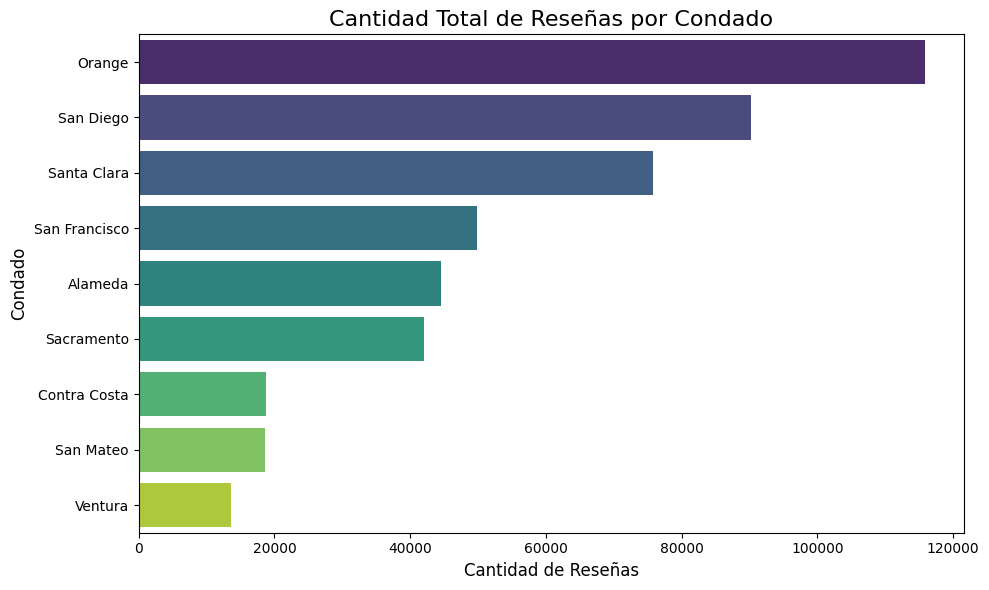

In [59]:
# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado, palette='viridis')

# Personalizar el gráfico
plt.title('Cantidad Total de Reseñas por Condado', fontsize=16)
plt.xlabel('Cantidad de Reseñas', fontsize=12)
plt.ylabel('Condado', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


La cantidad de reseñas de los condados 'industriales/tech' es de alta frecuencia. Analizando la diferencia que saca el condado de Orange, caemos en cuenta que dentro de esa zona de encuentra el popular 'Disney Anaheim Resort'. Esto no sólo aumenta la cantidad de valoraciones por su constante flujo de personas, sino que aumenta la cantidad de establecimientos vinculados a Disney World (dentro, aledaños y en camino).
Ahora podemos analizar la categoría de sus reseñas.

In [57]:
# Filtrar el DataFrame por los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_filtrados)]

# Agrupar por condado y categoría, sumando las reseñas para cada combinación
reseñas_por_condado_categoria = df_filtrado.groupby(['county', 'category'])['num_of_reviews'].sum().reset_index()

# Ordenar las reseñas dentro de cada condado
reseñas_por_condado_categoria = reseñas_por_condado_categoria.sort_values(by=['county', 'num_of_reviews'], ascending=[True, False])

# Tomar las 10 categorías con más reseñas para cada condado
top_10_categorias_por_condado = reseñas_por_condado_categoria.groupby('county').head(10).reset_index(drop=True)

# Mostrar el resultado
top_10_categorias_por_condado

county                                           category  num_of_reviews
0   Alameda                                 Mexican restaurant            5772
1   Alameda           Shopping mall, Grocery store, Restaurant            2448
2   Alameda  Restaurant, American restaurant, Dessert resta...            2150
3   Alameda  Grocery store, Cheese shop, Florist, Health fo...            1964
4   Alameda                                         Restaurant            1688
..      ...                                                ...             ...
85  Ventura                                             Bakery             597
86  Ventura  Japanese restaurant, Asian restaurant, Bar, Se...             480
87  Ventura  Sandwich shop, Caterer, Fast food restaurant, ...             445
88  Ventura  Fast food restaurant, Breakfast restaurant, Bu...             335
89  Ventura                  Sandwich shop, Takeout Restaurant             331

[90 rows x 3 columns]

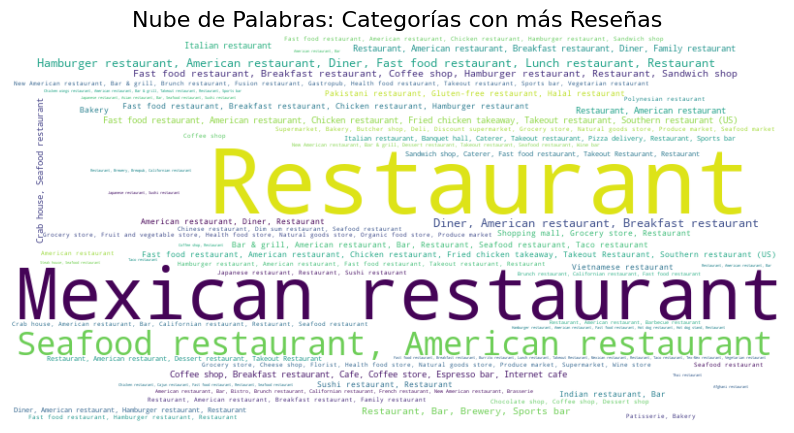

In [60]:
# Generar un diccionario con las categorías y la suma de sus reseñas
category_reseñas_dict = top_10_categorias_por_condado.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title('Nube de Palabras: Categorías con más Reseñas', fontsize=16)
plt.show()

Como observamos que hay una gran cantidad de restaurantes con valoraciones, que tienen la categoría 'Mexican Restaurant', podemos buscar la distribución demográfica y concluir que el centro y sur del Estado de California tiene mucha población de origen latina. [Puede observarse con más detalle aquí](https://www.bbc.com/mundo/noticias-internacional-47036609).
Ahora bien: muchos de los condados seleccionados se caracterizan no sólo por su avance y desarrollo industrial, sino por sus atractivos turísticos. Avancemos con el análisis de esos condados turísticos, antes de sacar conclusiones.

In [3]:
# Filtrar los nuevos condados especificados
condados_filtrados_nuevos = ['Los Ángeles', 'San Francisco', 'San Diego', 
                               'Orange', 'Monterey', 'Napa', 'Sonoma', 
                               'Santa Barbara', 'Marin', 'El Dorado']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado_nuevo = df_metadatos[df_metadatos['county'].isin(condados_filtrados_nuevos)]

# Calcular la suma total de num_of_reviews en los condados filtrados
suma_reseñas_nueva = df_filtrado_nuevo['num_of_reviews'].sum()

print(f'La suma total de reseñas en los condados seleccionados es: {suma_reseñas_nueva}')


La suma total de reseñas en los condados seleccionados es: 305106


In [62]:
# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado_nuevo = df_metadatos[df_metadatos['county'].isin(condados_filtrados_nuevos)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado_nuevo = df_filtrado_nuevo.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado_nuevo = reseñas_por_condado_nuevo.sort_values(by='num_of_reviews', ascending=False)

# Mostrar el resultado
print(reseñas_por_condado_nuevo)

          county  num_of_reviews
4         Orange          115803
5      San Diego           90272
6  San Francisco           49806
8         Sonoma           14488
7  Santa Barbara           13251
2       Monterey           10014
3           Napa            6307
0      El Dorado            2850
1          Marin            2315


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\1521479857.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado_nuevo, palette='viridis')


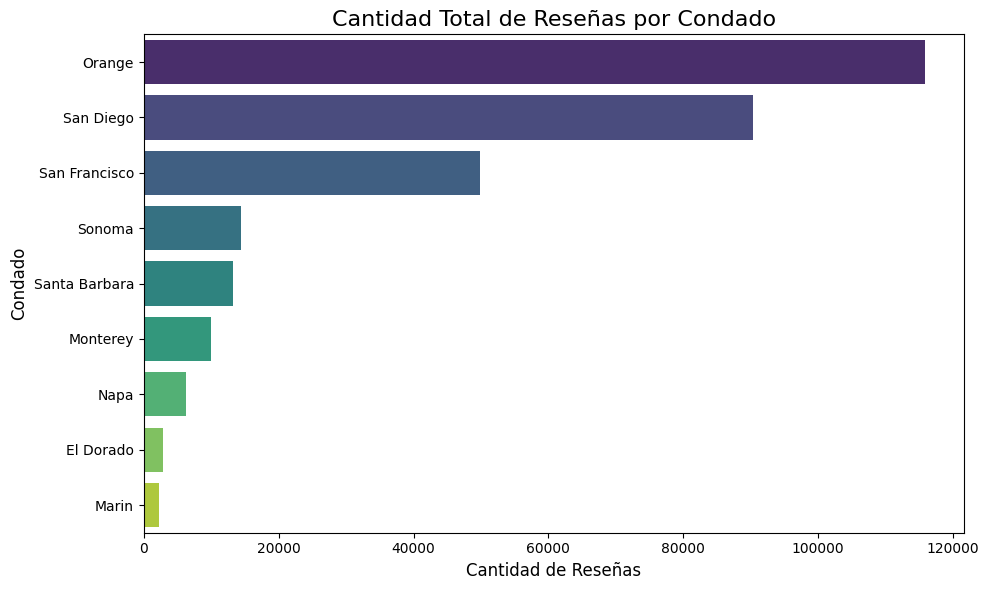

In [63]:
# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado_nuevo = df_filtrado_nuevo.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado_nuevo = reseñas_por_condado_nuevo.sort_values(by='num_of_reviews', ascending=False)

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='num_of_reviews', y='county', data=reseñas_por_condado_nuevo, palette='viridis')

# Personalizar el gráfico
plt.title('Cantidad Total de Reseñas por Condado', fontsize=16)
plt.xlabel('Cantidad de Reseñas', fontsize=12)
plt.ylabel('Condado', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [64]:
# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado_nuevo = df_metadatos[df_metadatos['county'].isin(condados_filtrados_nuevos)]

# Agrupar por condado y categoría, sumando las reseñas para cada combinación
reseñas_por_condado_categoria_nuevo = df_filtrado_nuevo.groupby(['county', 'category'])['num_of_reviews'].sum().reset_index()

# Ordenar las reseñas dentro de cada condado
reseñas_por_condado_categoria_nuevo = reseñas_por_condado_categoria_nuevo.sort_values(by=['county', 'num_of_reviews'], ascending=[True, False])

# Tomar las 10 categorías con más reseñas para cada condado
top_10_categorias_por_condado_nuevo = reseñas_por_condado_categoria_nuevo.groupby('county').head(10).reset_index(drop=True)

# Mostrar el resultado
print(top_10_categorias_por_condado_nuevo)

       county                                           category  \
0   El Dorado                 German restaurant, Bar, Restaurant   
1   El Dorado                     Italian restaurant, Restaurant   
2   El Dorado              Japanese restaurant, Sushi restaurant   
3   El Dorado  Sandwich shop, Caterer, Fast food restaurant, ...   
4   El Dorado                                    Bar, Restaurant   
..        ...                                                ...   
85     Sonoma                  Bakery, Cookie shop, Dessert shop   
86     Sonoma               Cafe, Restaurant, Seafood restaurant   
87     Sonoma                                 Mexican restaurant   
88     Sonoma                                 Chinese restaurant   
89     Sonoma                                             Bakery   

    num_of_reviews  
0              918  
1              275  
2              245  
3              211  
4              208  
..             ...  
85             578  
86             

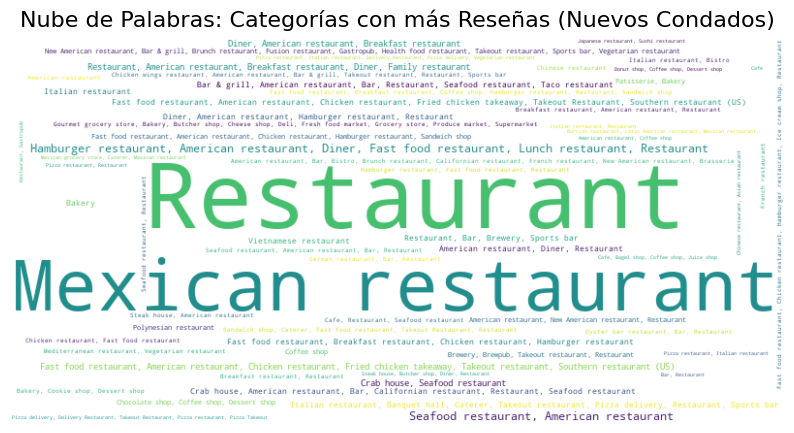

In [65]:
# Generar un diccionario con las categorías y la suma de sus reseñas para los nuevos condados
category_reseñas_dict_nuevo = top_10_categorias_por_condado_nuevo.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras
wordcloud_nueva = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_nuevo)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_nueva, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title('Nube de Palabras: Categorías con más Reseñas (Nuevos Condados)', fontsize=16)
plt.show()

La gran presencia de población hispana una vez más se impone, lo que se demuestra con la popularidad de los establecimientos de 'Mexican restaurant' en los condados turísticos. Atención: esto también puede ser un indicador de turistas latinoamericanos o 'hispano hablantes'.
Ahora bien, si dejamos de lado esa avasallante popularidad, podemos observar dos grandes tendencias: las "comidas rápidas" (burger, pizza, fast food) y las "comidas de mar" (seafood, crab house). Cabe mencionar que California limita con el Océano Pacífico, ofreciendo entre sus atractivos con populares balnearios.

**Mejoremos la clasificación**

In [4]:
# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Crear una nueva columna para clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_condado['Tipo'] = reseñas_por_condado['county'].apply(clasificar_condado)

# Agrupar por tipo de condado y sumar las reseñas
reseñas_por_tipo = reseñas_por_condado.groupby('Tipo')['num_of_reviews'].sum().reset_index()

# Mostrar el resultado
print(reseñas_por_tipo)


                        Tipo  num_of_reviews
0                   Híbridos          255881
1  Industriales/Tecnológicos          171315
2                 Turísticos           49225


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\514065865.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tipo', y='num_of_reviews', data=reseñas_por_tipo, palette='pastel')


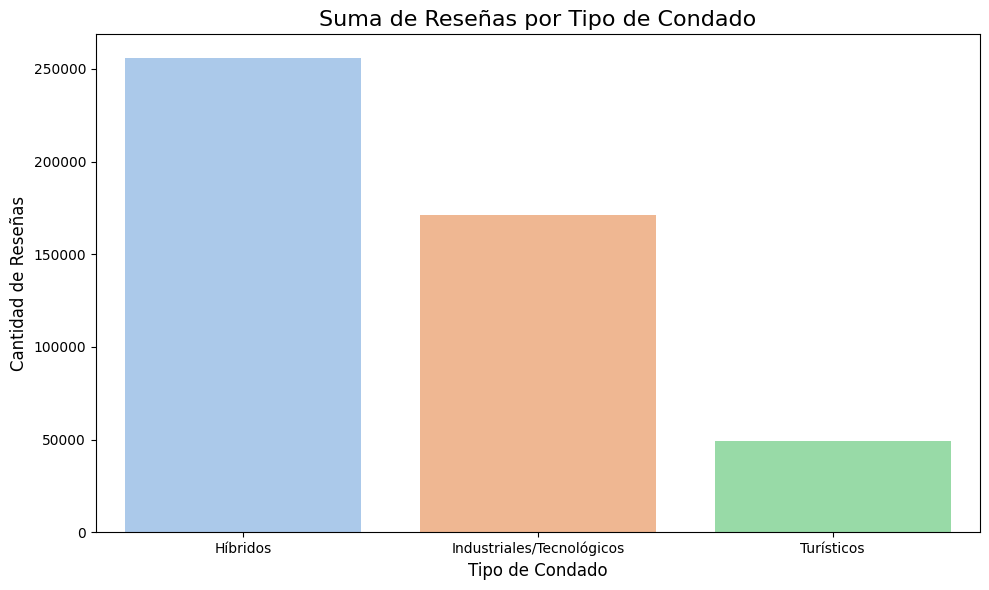

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado, sumar las reseñas, y ordenar de mayor a menor
reseñas_por_condado = df_filtrado.groupby('county')['num_of_reviews'].sum().reset_index()
reseñas_por_condado = reseñas_por_condado.sort_values(by='num_of_reviews', ascending=False)

# Crear una nueva columna para clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_condado['Tipo'] = reseñas_por_condado['county'].apply(clasificar_condado)

# Agrupar por tipo de condado y sumar las reseñas
reseñas_por_tipo = reseñas_por_condado.groupby('Tipo')['num_of_reviews'].sum().reset_index()

# Graficar el resultado
plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo', y='num_of_reviews', data=reseñas_por_tipo, palette='pastel')

# Personalizar el gráfico
plt.title('Suma de Reseñas por Tipo de Condado', fontsize=16)
plt.xlabel('Tipo de Condado', fontsize=12)
plt.ylabel('Cantidad de Reseñas', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\1024413720.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)


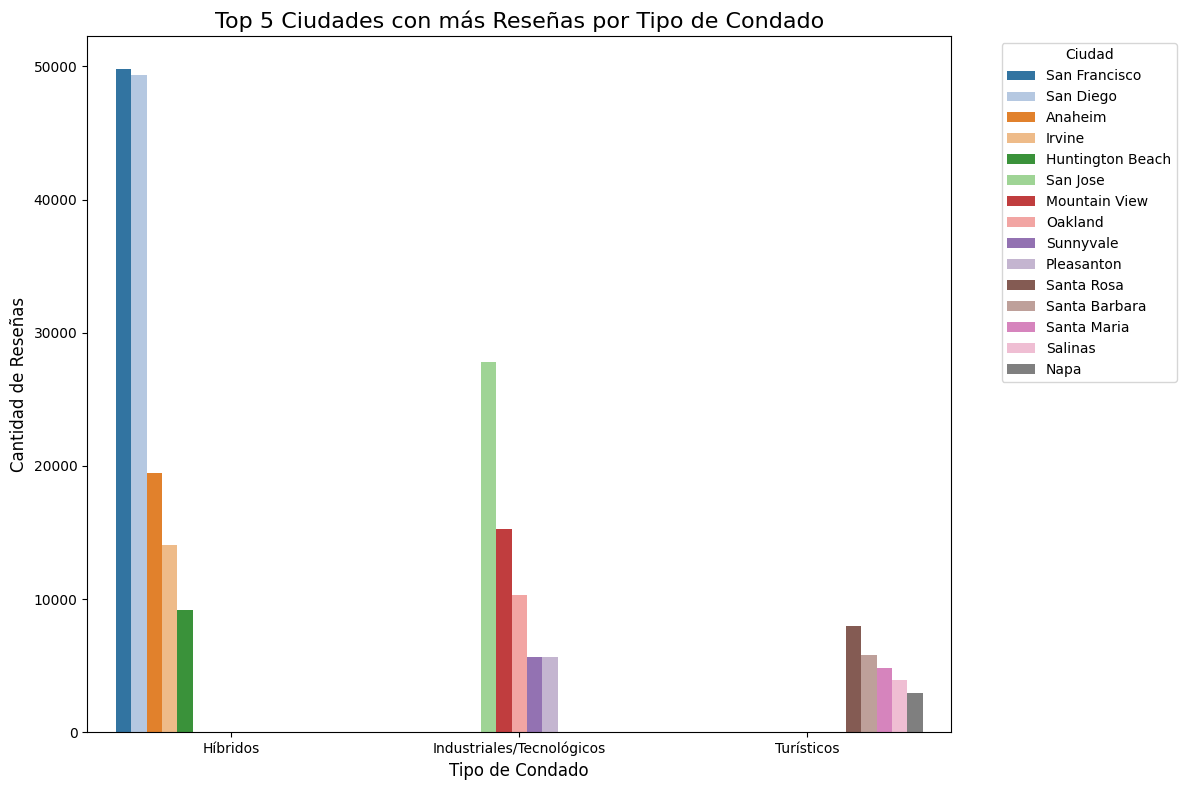

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado y ciudad, sumando las reseñas
reseñas_por_ciudad = df_filtrado.groupby(['county', 'city'])['num_of_reviews'].sum().reset_index()

# Clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_ciudad['Tipo'] = reseñas_por_ciudad['county'].apply(clasificar_condado)

# Filtrar el top 5 de ciudades con más reseñas por grupo
top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)

# Crear el gráfico de columnas apiladas
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_ciudades_por_tipo, x='Tipo', y='num_of_reviews', hue='city', palette='tab20')

# Personalizar el gráfico
plt.title('Top 5 Ciudades con más Reseñas por Tipo de Condado', fontsize=16)
plt.xlabel('Tipo de Condado', fontsize=12)
plt.ylabel('Cantidad de Reseñas', fontsize=12)
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [71]:
# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Filtrar el DataFrame para solo tener los condados de interés
df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_hibridos + condados_turisticos + condados_industriales)]

# Agrupar por condado y ciudad, sumando las reseñas
reseñas_por_ciudad = df_filtrado.groupby(['county', 'city'])['num_of_reviews'].sum().reset_index()

# Clasificar los condados
def clasificar_condado(condado):
    if condado in condados_hibridos:
        return 'Híbridos'
    elif condado in condados_turisticos:
        return 'Turísticos'
    elif condado in condados_industriales:
        return 'Industriales/Tecnológicos'
    return 'Otro'

reseñas_por_ciudad['Tipo'] = reseñas_por_ciudad['county'].apply(clasificar_condado)

# Filtrar el top 5 de ciudades con más reseñas por grupo
top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)

# Mostrar la tabla con el top 5
top_5_ciudades_por_tipo


C:\Users\GASTON\AppData\Local\Temp\ipykernel_17096\1158145121.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_ciudades_por_tipo = reseñas_por_ciudad.groupby('Tipo').apply(lambda x: x.nlargest(5, 'num_of_reviews')).reset_index(drop=True)


county              city  num_of_reviews                       Tipo
0   San Francisco     San Francisco           49806                   Híbridos
1       San Diego         San Diego           49327                   Híbridos
2          Orange           Anaheim           19452                   Híbridos
3          Orange            Irvine           14034                   Híbridos
4          Orange  Huntington Beach            9192                   Híbridos
5     Santa Clara          San Jose           27828  Industriales/Tecnológicos
6     Santa Clara     Mountain View           15295  Industriales/Tecnológicos
7         Alameda           Oakland           10294  Industriales/Tecnológicos
8     Santa Clara         Sunnyvale            5680  Industriales/Tecnológicos
9         Alameda        Pleasanton            5654  Industriales/Tecnológicos
10         Sonoma        Santa Rosa            7949                 Turísticos
11  Santa Barbara     Santa Barbara            5771                 Turísticos
12  Santa Barbara       Santa Maria            4849                 Turísticos
13       Monterey           Salinas            3938                 Turísticos
14           Napa              Napa            2944                 Turísticos

Podemos visualizar cómo emerge con otros patrones de comportamiento y de preferencias un grupo de condados "híbridos", en los que hay un gran desarrollo empresarial, pero también un fuerte nivel de atracción turística.
Analicemos las reseñas de los locales más comerciales con una nube de palabras, para poder analizar esas preferencias.

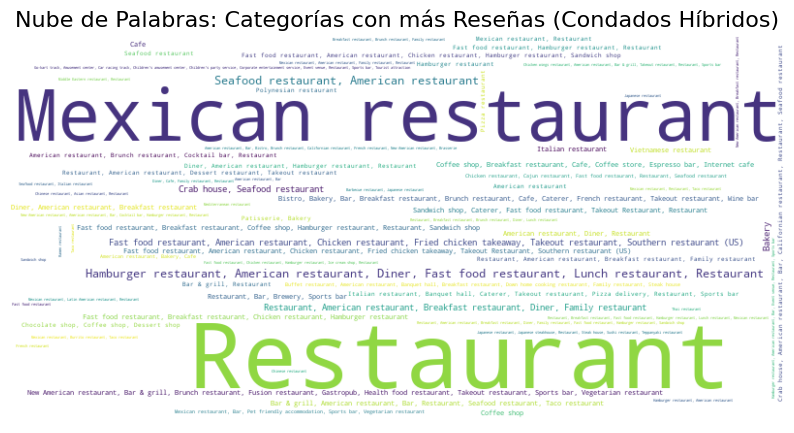

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtrar las reseñas por los condados híbridos
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)]

# Agrupar por categoría y sumar las reseñas
category_reseñas_dict_hibridos = df_hibridos.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras para condados híbridos
wordcloud_hibridos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_hibridos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_hibridos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Categorías con más Reseñas (Condados Híbridos)', fontsize=16)
plt.show()


**Ahora analicemos los condados exclusivamente "turísticos"**

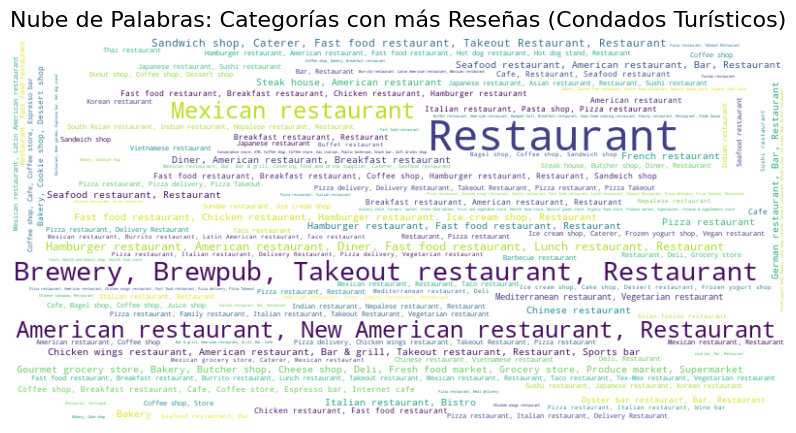

In [73]:
# Filtrar las reseñas por los condados turísticos
df_turisticos = df_metadatos[df_metadatos['county'].isin(condados_turisticos)]

# Agrupar por categoría y sumar las reseñas
category_reseñas_dict_turisticos = df_turisticos.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras para condados turísticos
wordcloud_turisticos = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_turisticos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_turisticos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Categorías con más Reseñas (Condados Turísticos)', fontsize=16)
plt.show()


**Por útimo, veamos los condados exclusivamente "industriales"**.

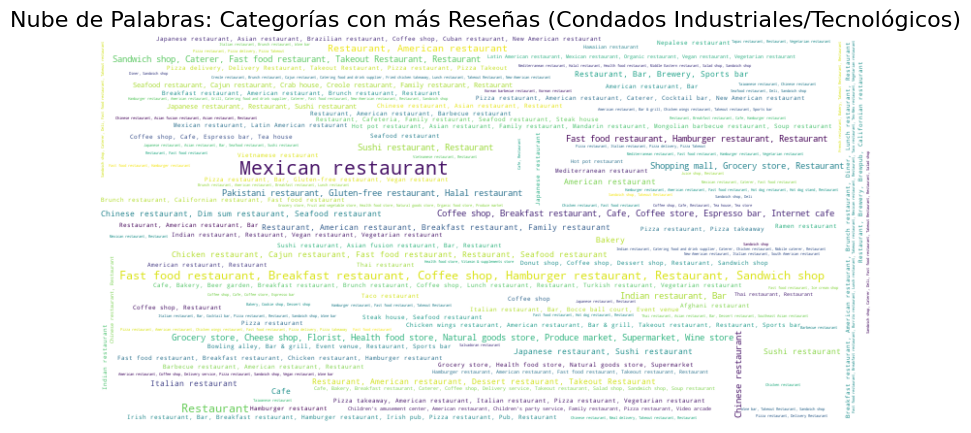

In [74]:
# Filtrar las reseñas por los condados industriales/tecnológicos
df_industriales = df_metadatos[df_metadatos['county'].isin(condados_industriales)]

# Agrupar por categoría y sumar las reseñas
category_reseñas_dict_industriales = df_industriales.groupby('category')['num_of_reviews'].sum().to_dict()

# Crear la nube de palabras para condados industriales/tecnológicos
wordcloud_industriales = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_reseñas_dict_industriales)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_industriales, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Categorías con más Reseñas (Condados Industriales/Tecnológicos)', fontsize=16)
plt.show()


Con este análisis podemos obtener algunas conclusiones.
- La comida mexicana tiene gran popularidad en el Estado de California.
Ya hemos referido el contexto demográfico de la población de habla hispana, y su injerencia en el mercado gastronómico no es ajena a tal suceso.
La cantidad de reseñas es un índicio de popularidad. Sin embargo, la popularidad de estos comercios no se explican sólo en la cantidad de habitantes de origen hispano; sino que se puede visualizar un gusto generalizado por la comida mexicana. La cercanía territorial con latinoamérica suele motivar a los ciudadanos locales a adoptar culturas vecinas. También podemos presumir que hay gran cantidad de turistas de habla hispana, que puede continuar agigantando la tendencia. 

- Las comunidades marcan tendencias gastronómicas.
Sería injusto limitar el análisis cultural a los ciudadanos, turistas (y consumidores en general) con relación hispana: contamos con un subgrupo asiático (comida china, india, japonesa y otras) que tiene una fuerte presencia. También observamos que, solitariamente, se destaca la cocina italiana (o trattorias).
Un caso curioso es la 'cocina americana' (o 'american restaurant'): tiene una fuerte presencia en este análisis de popularidad, sobre todo en los sectores industriales o híbridos. El problema que tiene es que, a partir de una observación más cercana, ésta categoría suele llevar a la confusión: contempla tanto la cocina americana (grill, cocina a fuego alto, platos eminentemente occidentales) con el servicio 'estilo americano' (emplatado en cocina).

- En las zonas "turísticas" existe una mayor popularidad del subgrupo de "comidas rápidas". Observamos que 'fast food', 'sandwich', 'pizza', 'burger', 'chicken wings', son palabras con una fuerte presencia. Aquí no puede dejar de señalarse algo que ya se había referido: **hay gran popularidad de comidas de mar**: 'seafood', 'crab  house', 'crab', y otras. Esto, como ya se había mencionado, va de la mano a las zonas turísticas analizadas. La mayoría de los condados estudiados cuentan con ciudades costeras, y la comida de mar o 'seafood' es una atracción turística por sí mísma.

- En las zonas 'tecnológicas' o 'industriales' se observa mucha más diversidad respecto a la popularidad de las vairedades de comida. Resulta que allí podemos ver más distribuido el número de opciones que los clientes habitualmente eligen, a diferencia de los condados más turísticos, en donde hay un espectro mucho más limitado de categorías populares.


In [12]:
# Agrupar las palabras clave por categorías
palabras_clave_agrupadas = {
    'Comida asiática': ['japanese', 'asian', 'chinese', 'indian'],
    'Comida centroamericana': ['mexican','cuban'],
    'Comida americana': ['american'],
    'Comida italiana': ['italian'],
    'Sandwiches': ['sandwich'],
    'Hamburguesas': ['burger', 'hamburger'],
    'Pizza': ['pizza'],
    'Café y bebidas': ['coffee', 'cafe', 'espresso'],
    'Desayuno/Brunch': ['breakfast', 'brunch'],
    'Comida saludable': ['health', 'vegan', 'vegetarian', 'green', 'natural', 'salads', 'soup']
}

# Filtrar las reseñas por los condados industriales/tecnológicos
df_industriales = df_metadatos[df_metadatos['county'].isin(condados_industriales)]

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_industriales['category'].str.lower()

# Inicializar un diccionario para contar las apariciones de cada grupo de palabras clave
conteo_palabras_agrupadas = {grupo: 0 for grupo in palabras_clave_agrupadas}

# Contar las apariciones de cada conjunto de palabras clave en las categorías
for grupo, palabras in palabras_clave_agrupadas.items():
    for palabra in palabras:
        conteo_palabras_agrupadas[grupo] += categorias_bajas.str.contains(palabra).sum()

# Mostrar los resultados
for grupo, conteo in conteo_palabras_agrupadas.items():
    print(f"El grupo '{grupo}' aparece {conteo} veces en las categorías.")


El grupo 'Comida asiática' aparece 199 veces en las categorías.
El grupo 'Comida centroamericana' aparece 115 veces en las categorías.
El grupo 'Comida americana' aparece 71 veces en las categorías.
El grupo 'Comida italiana' aparece 41 veces en las categorías.
El grupo 'Sandwiches' aparece 165 veces en las categorías.
El grupo 'Hamburguesas' aparece 68 veces en las categorías.
El grupo 'Pizza' aparece 88 veces en las categorías.
El grupo 'Café y bebidas' aparece 312 veces en las categorías.
El grupo 'Desayuno/Brunch' aparece 78 veces en las categorías.
El grupo 'Comida saludable' aparece 100 veces en las categorías.


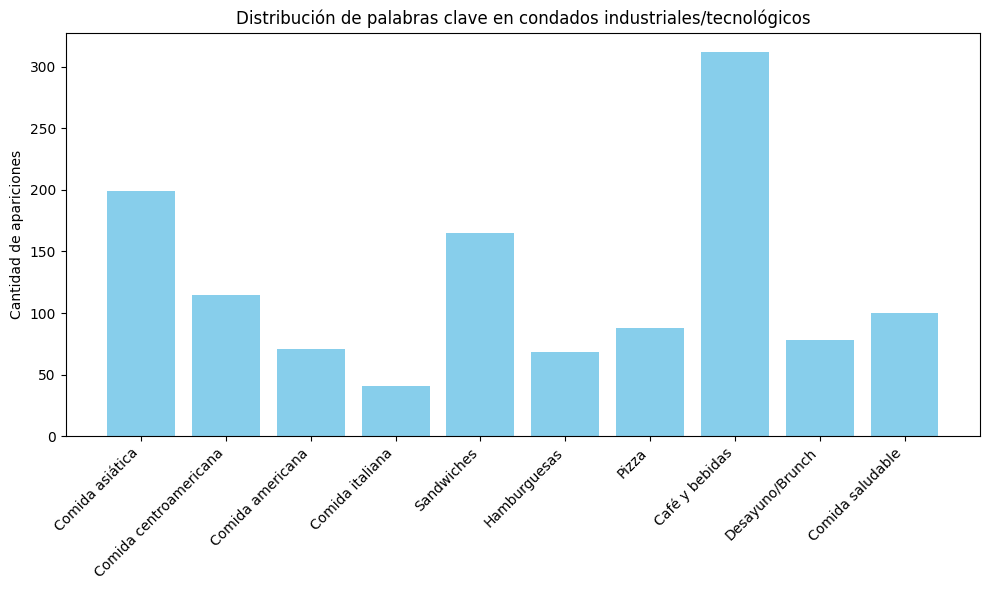

In [13]:

# Graficar la distribución de palabras clave
plt.figure(figsize=(10, 6))
plt.bar(conteo_palabras_agrupadas.keys(), conteo_palabras_agrupadas.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de apariciones')
plt.title('Distribución de palabras clave en condados industriales/tecnológicos')
plt.tight_layout()
plt.show()

Esta gráfica nos permite ratificar una mayor distribución de categorías, y algunas conclusiones adicionales sobre las ciudades industriales o polos tecnológicos:
- En menor medida que en los condados "turísticos", hay un gran consumo de comidas rápidas. **Esto es importante, ya que no queremos dar a nuestro cliente la errónea apreciación de que en los condados industriales no sería acertado establecer emprendimientos de comida rápida**. 
De hecho, podemos ver [aquí](https://cnnespanol.cnn.com/2018/10/04/comida-rapida-estados-unidos-consumo-cuanta-respuesta) que Estados Unidos tiene un altísimo consumo de comidas rápidas: en promedio y por día, un 37% de los ciudadanos consumen "comidas rápidas".

- Hay un gran consumo de "comidas saludables" en los condados más industrializados:
Esto se puede explicar a partir de políticas empresariales tendientes a modificar los hábitos alimenticios. Entonces, deviene lógico que, en zonas donde se han establecido grandes empresas, exista una adaptación a esas nuevas tendencias. De hecho, es interesante [este reporte](https://www.linkedin.com/pulse/snack-attack-por-qu%C3%A9-google-y-otras-empresas-alimentan-sus-empleados/) que explica los motivos detrás de las empresas buscando, no sólo modificar hábitos alimenticios, sino la cultura empresarial en general. Lo que nos lleva a recordar, entonces, que este consumo saludable suele ser en momentos en donde los empleados no se encuentran en sus trabajos (donde cuentan con esos alimentos en forma gratuita). Por ello, la popularidad es particularmente interesante. Podemos decir que este tipo de locales tienen mejor recepción en ciudades "tech".

- Se observa una gran popularidad de las cafeterías en las zonas industriales o tech:
Tiene mucho sentido: el "polo tecnológico" es un gran consumidor de café. Forma parte de la cultura laboral en grandes empresas, sobre todos las del rubro tecnológico. Y no sólo por el consumo propiamente dicho, sino que alrededor de los locales de Café se ha construido un momento de dispersión, un "break" de las tareas que, en ocasiones, también resulta ser el ambiente más apropiado para el trabajo. Al abarcar ese gran espectro, sumado al disfrute de esas tiendas, que por lo general también cuentan con pastelería y otras comidas asociadas, este rubro se termina posicionando como uno de los principales, tanto en los condados industriales como en aquellos "híbridos".


In [15]:
# Filtrar las reseñas por los condados híbridos
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)]

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_hibridos['category'].str.lower()

# Inicializar un diccionario para contar las apariciones de cada grupo de palabras clave
conteo_palabras_agrupadas = {grupo: 0 for grupo in palabras_clave_agrupadas}

# Contar las apariciones de cada conjunto de palabras clave en las categorías
for grupo, palabras in palabras_clave_agrupadas.items():
    for palabra in palabras:
        conteo_palabras_agrupadas[grupo] += categorias_bajas.str.contains(palabra).sum()

# Mostrar los resultados
for grupo, conteo in conteo_palabras_agrupadas.items():
    print(f"El grupo '{grupo}' aparece {conteo} veces en las categorías.")

El grupo 'Comida asiática' aparece 190 veces en las categorías.
El grupo 'Comida centroamericana' aparece 156 veces en las categorías.
El grupo 'Comida americana' aparece 125 veces en las categorías.
El grupo 'Comida italiana' aparece 46 veces en las categorías.
El grupo 'Sandwiches' aparece 161 veces en las categorías.
El grupo 'Hamburguesas' aparece 84 veces en las categorías.
El grupo 'Pizza' aparece 86 veces en las categorías.
El grupo 'Café y bebidas' aparece 403 veces en las categorías.
El grupo 'Desayuno/Brunch' aparece 120 veces en las categorías.
El grupo 'Comida saludable' aparece 141 veces en las categorías.


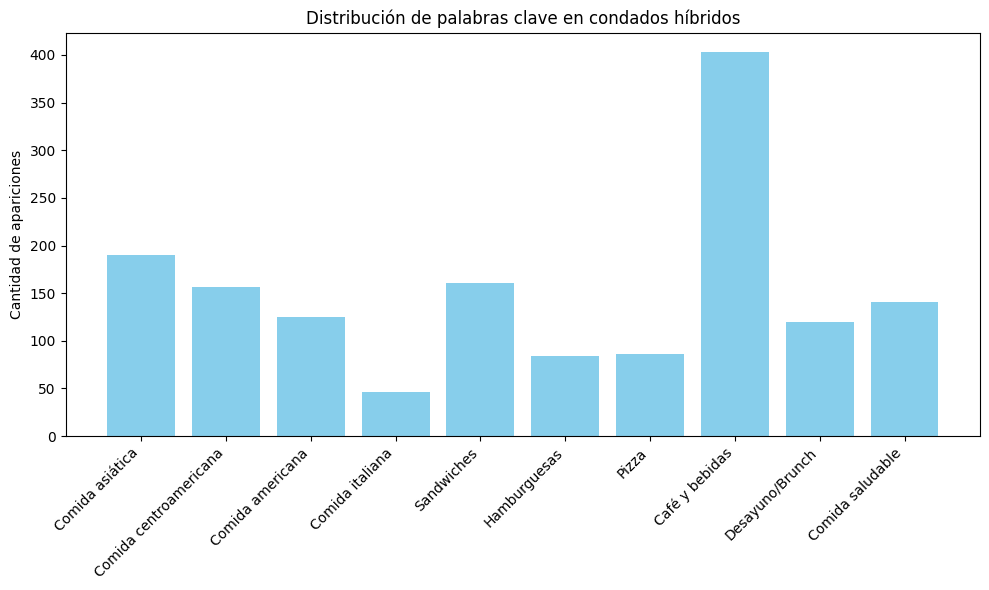

In [16]:
# Graficar la distribución de palabras clave
plt.figure(figsize=(10, 6))
plt.bar(conteo_palabras_agrupadas.keys(), conteo_palabras_agrupadas.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de apariciones')
plt.title('Distribución de palabras clave en condados híbridos')
plt.tight_layout()
plt.show()

Como vemos, en los condados en los que se destaca tanto la actividad industrial o tecnológica como la actividad turística, también se destaca la popularidad de las tiengas de Café. 
También vemos que se mantiene la tendencia respecto a la "comida saludable" que habíamos analizado en los polos tech.

Podemos identificar una gran flexibilidad de estos condados "híbridos" a la hora de recibir nuevos establecimientos, ya que rompen el esquema que venimos analizando y, contrariamente a lo que se podía presumir, no hay una inclinación a determinado rubro asociado a una zona, desactivando la potencialidad del otro: lo que termina sucediendo es que los polos "híbridos" tienen tanta cantidad de habitantes y tránsito de personas, que la popularidad no se ve afectada, sino que es una sumatoria de ambas zonas. 
Esta apreciación resulta inédita, y ha de ser tenida en cuenta para el asesoramiento particular a nuestros clientes.

# ¿Cuáles son las ciudades de condados híbridos más interesantes?

Bien, si tomamos en cuenta sólo la popularidad de sus establecimientos gastronómicos, podemos obtener una conclusión como esta.

In [23]:
# Normalizar los nombres de los condados para evitar inconsistencias (minúsculas y eliminar espacios en blanco)
df_metadatos['county'] = df_metadatos['county'].str.strip().str.lower()

# Convertir los nombres de los condados híbridos a minúsculas para la comparación
condados_hibridos = ['los angeles', 'san francisco', 'orange', 'san diego']

# Filtrar las reseñas solo por los condados híbridos
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)]

# Verificar si se están filtrando los 4 condados
print(f"Condados encontrados después del filtrado: {df_hibridos['county'].unique()}")

# Crear una lista para almacenar los resultados del top 5 de ciudades con más reseñas por condado
resultados_top_ciudades_reseñas = []

# Iterar sobre cada condado en los condados híbridos
for condado in condados_hibridos:
    # Filtrar por el condado actual
    ciudades_en_condado = df_hibridos[df_hibridos['county'] == condado]
    
    # Obtener el top 5 de ciudades con más reseñas
    top_ciudades_reseñas = ciudades_en_condado.groupby('city')['num_of_reviews'].sum().reset_index()
    top_ciudades_reseñas = top_ciudades_reseñas.rename(columns={'num_of_reviews': 'total_reseñas'})
    top_ciudades_reseñas = top_ciudades_reseñas.sort_values(by='total_reseñas', ascending=False).head(5)
    
    # Añadir el condado como columna en el resultado
    top_ciudades_reseñas['county'] = condado
    
    # Agregar el resultado a la lista
    resultados_top_ciudades_reseñas.append(top_ciudades_reseñas)

# Concatenar todos los resultados en un solo DataFrame (20 ciudades en total: 5 por cada condado)
df_resultados_reseñas = pd.concat(resultados_top_ciudades_reseñas, ignore_index=True)

# Mostrar los resultados
print(df_resultados_reseñas)


Condados encontrados después del filtrado: ['los angeles' 'san diego' 'san francisco' 'orange']
                city  total_reseñas         county
0        Los Angeles          90466    los angeles
1         Long Beach          11662    los angeles
2            Gardena           8064    los angeles
3           Pasadena           5630    los angeles
4           Lawndale           5460    los angeles
5      San Francisco          49806  san francisco
6            Anaheim          19452         orange
7             Irvine          14034         orange
8   Huntington Beach           9192         orange
9         Costa Mesa           8603         orange
10         Santa Ana           8021         orange
11         San Diego          49327      san diego
12       Chula Vista           8148      san diego
13         Oceanside           4903      san diego
14         Escondido           3063      san diego
15          Carlsbad           2702      san diego


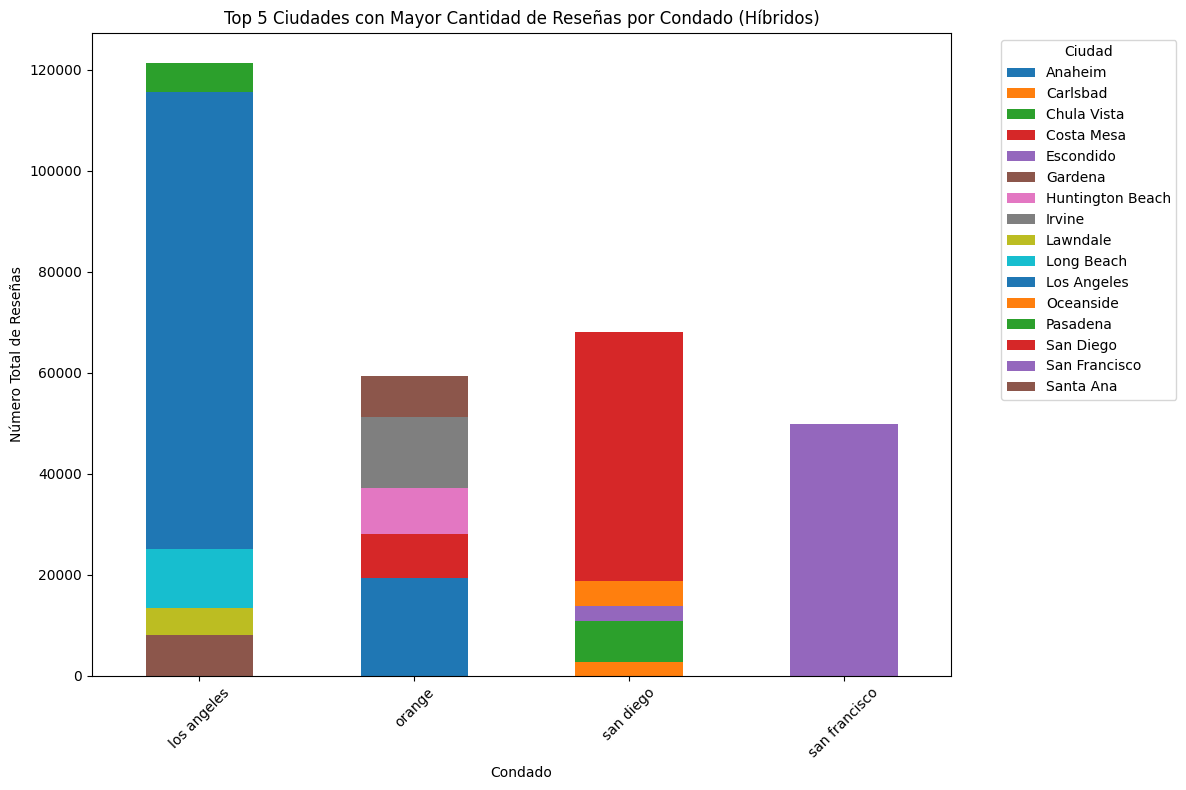

In [24]:
# Crear un DataFrame para las ciudades en formato adecuado para gráfico
df_resultados_pivot_reseñas = df_resultados_reseñas.pivot(index='county', columns='city', values='total_reseñas').fillna(0)

# Crear el gráfico de columnas apiladas
plt.figure(figsize=(12, 8))
df_resultados_pivot_reseñas.plot(kind='bar', stacked=True, ax=plt.gca(), color=plt.cm.tab10.colors)

plt.title('Top 5 Ciudades con Mayor Cantidad de Reseñas por Condado (Híbridos)')
plt.xlabel('Condado')
plt.ylabel('Número Total de Reseñas')
plt.xticks(rotation=45)
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Además de San Francisco (Ciudad-Condado), esas son las 5 ciudades de cada uno de los Estados Híbridos con mejor recepción: dan una gran popularidad a sus locales gastronómicos. Esto las hace interesantes para recibir ciertas inversiones.

**Establecimientos con servicios externos**

Los servicios externos son aquellos en los que el local gastronómico ofrece determinado producto para el consumo *fuera del local*. Por lo hasta aquí analizado, estos servicios parecen estar focalizados en las zonas más industriales e híbridas, que en los polos gastronómicos. Revisemos los datos por grupo de condados, para confirmarlo.

In [6]:
# Definir los grupos de condados
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
condados_turisticos = ['Monterey', 'Napa', 'Sonoma', 'Santa Barbara', 'Marin', 'El Dorado']
condados_industriales = ['Santa Clara', 'San Mateo', 'Alameda', 'Contra Costa', 'Ventura']

# Lista de palabras clave que queremos buscar
palabras_clave = ['delivery', 'takeout']

# Filtrar las categorías que contienen alguna de las palabras clave (sin distinción entre mayúsculas y minúsculas)
filtro_categorias = df_metadatos['category'].str.contains('|'.join(palabras_clave), case=False)

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Función para contar registros por condado y palabras clave
def contar_registros_por_grupo(condados_grupo, nombre_grupo):
    df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_grupo) & filtro_categorias]
    conteo_palabras = {palabra: categorias_bajas[df_filtrado.index].str.count(palabra).sum() for palabra in palabras_clave}
    
    # Mostrar resultados
    print(f"\nGrupo: {nombre_grupo}")
    print(f"Total de registros con las palabras clave en las categorías: {len(df_filtrado)}")
    for palabra, conteo in conteo_palabras.items():
        print(f"La palabra '{palabra}' aparece {conteo} veces en este grupo.")

# Contar registros para cada grupo de condados
contar_registros_por_grupo(condados_hibridos, 'Condados Híbridos')
contar_registros_por_grupo(condados_turisticos, 'Condados Turísticos')
contar_registros_por_grupo(condados_industriales, 'Condados Industriales/Tecnológicos')



Grupo: Condados Híbridos
Total de registros con las palabras clave en las categorías: 202
La palabra 'delivery' aparece 82 veces en este grupo.
La palabra 'takeout' aparece 172 veces en este grupo.

Grupo: Condados Turísticos
Total de registros con las palabras clave en las categorías: 64
La palabra 'delivery' aparece 21 veces en este grupo.
La palabra 'takeout' aparece 61 veces en este grupo.

Grupo: Condados Industriales/Tecnológicos
Total de registros con las palabras clave en las categorías: 208
La palabra 'delivery' aparece 73 veces en este grupo.
La palabra 'takeout' aparece 191 veces en este grupo.


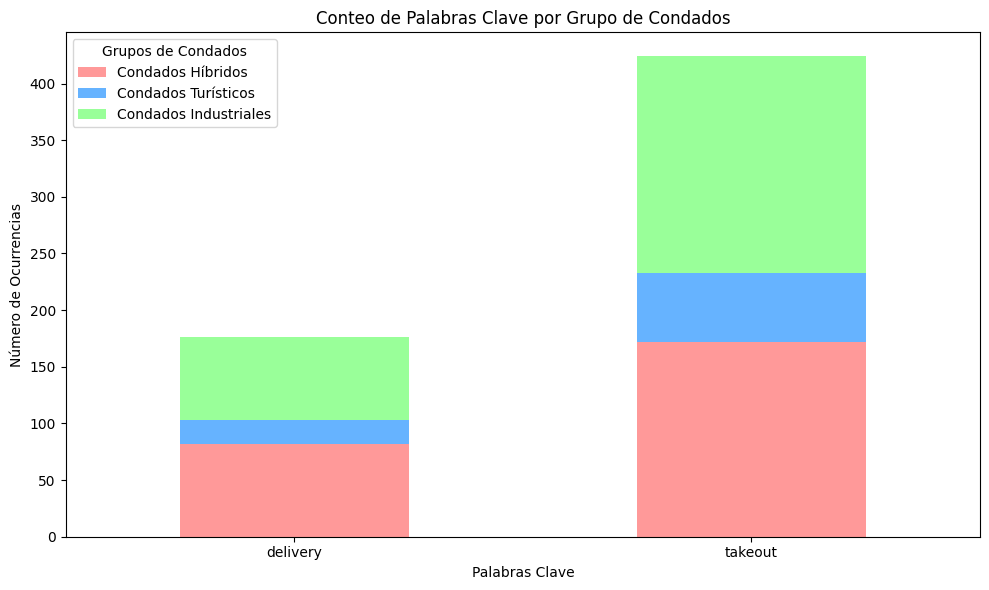

In [7]:
# Lista de palabras clave que queremos buscar
palabras_clave = ['delivery', 'takeout']

# Filtrar las categorías que contienen alguna de las palabras clave (sin distinción entre mayúsculas y minúsculas)
filtro_categorias = df_metadatos['category'].str.contains('|'.join(palabras_clave), case=False)

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Función para contar registros por condado y palabras clave
def contar_registros_por_grupo(condados_grupo):
    df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_grupo) & filtro_categorias]
    conteo_palabras = {palabra: categorias_bajas[df_filtrado.index].str.count(palabra).sum() for palabra in palabras_clave}
    return conteo_palabras

# Contar registros para cada grupo de condados
conteo_hibridos = contar_registros_por_grupo(condados_hibridos)
conteo_turisticos = contar_registros_por_grupo(condados_turisticos)
conteo_industriales = contar_registros_por_grupo(condados_industriales)

# Crear un DataFrame con los resultados
df_conteo = pd.DataFrame({
    'Condados Híbridos': list(conteo_hibridos.values()),
    'Condados Turísticos': list(conteo_turisticos.values()),
    'Condados Industriales': list(conteo_industriales.values())
}, index=palabras_clave)

# Graficar los resultados en un gráfico de barras apiladas
df_conteo.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999', '#66b3ff', '#99ff99'])

# Configuración del gráfico
plt.title('Conteo de Palabras Clave por Grupo de Condados')
plt.ylabel('Número de Ocurrencias')
plt.xlabel('Palabras Clave')
plt.xticks(rotation=0)
plt.legend(title='Grupos de Condados')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

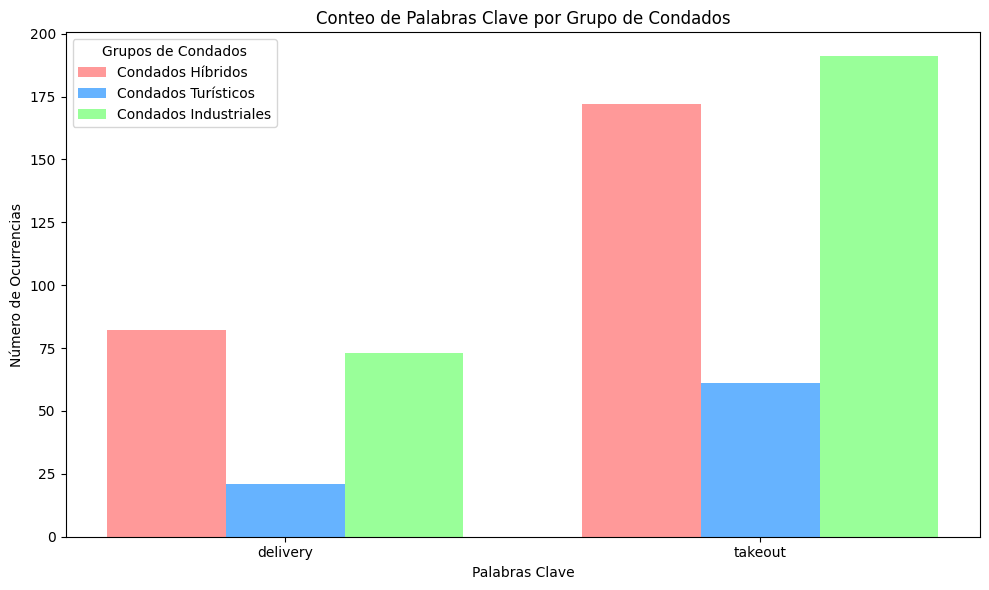

In [9]:
# Lista de palabras clave que queremos buscar
palabras_clave = ['delivery', 'takeout']

# Filtrar las categorías que contienen alguna de las palabras clave (sin distinción entre mayúsculas y minúsculas)
filtro_categorias = df_metadatos['category'].str.contains('|'.join(palabras_clave), case=False)

# Convertir la columna 'category' a minúsculas para hacer la búsqueda insensible a mayúsculas
categorias_bajas = df_metadatos['category'].str.lower()

# Función para contar registros por condado y palabras clave
def contar_registros_por_grupo(condados_grupo):
    df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_grupo) & filtro_categorias]
    conteo_palabras = {palabra: categorias_bajas[df_filtrado.index].str.count(palabra).sum() for palabra in palabras_clave}
    return conteo_palabras

# Contar registros para cada grupo de condados
conteo_hibridos = contar_registros_por_grupo(condados_hibridos)
conteo_turisticos = contar_registros_por_grupo(condados_turisticos)
conteo_industriales = contar_registros_por_grupo(condados_industriales)

# Crear un DataFrame con los resultados
df_conteo = pd.DataFrame({
    'Condados Híbridos': list(conteo_hibridos.values()),
    'Condados Turísticos': list(conteo_turisticos.values()),
    'Condados Industriales': list(conteo_industriales.values())
}, index=palabras_clave)

# Configuración para gráficos sin apilar
bar_width = 0.25  # Ancho de las barras
indices = np.arange(len(palabras_clave))  # Posiciones de las barras

# Crear el histograma
plt.figure(figsize=(10, 6))

# Barras para cada grupo de condados
plt.bar(indices, df_conteo['Condados Híbridos'], bar_width, label='Condados Híbridos', color='#ff9999')
plt.bar(indices + bar_width, df_conteo['Condados Turísticos'], bar_width, label='Condados Turísticos', color='#66b3ff')
plt.bar(indices + 2 * bar_width, df_conteo['Condados Industriales'], bar_width, label='Condados Industriales', color='#99ff99')

# Configuración del gráfico
plt.title('Conteo de Palabras Clave por Grupo de Condados')
plt.xlabel('Palabras Clave')
plt.ylabel('Número de Ocurrencias')
plt.xticks(indices + bar_width, palabras_clave)  # Ajustar las etiquetas en el eje X
plt.legend(title='Grupos de Condados')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

En efecto, en las zonas exclusivamente turísticas baja el ofrecimiento de servicios de 'delivery' y 'takeout'. Los mismos son mucho más considerables en los condados industriales.
El control sobre los condados híbridos permite controlar si hay cambios en la tendencia, lo que no ocurre en este caso.

Esto nos permite concluir que, de crearse nuevos establecimientos en las zonas "industriales" o "tech", es recomendable valerse de servicios de Delivery o Takeout, ya que tienen mayor recepción en esa zona.

**Promedio de Reseñas**

Una vez analizada la popularidad de los establecimientos gastronómicos, podemos observar su calidad a través del promedio de rating: puntaje promedio (de 1 a 5) que acompaña a las reseñas.

In [28]:
# Convertir los nombres de los condados en df_metadatos a minúsculas para normalizar
df_metadatos['county'] = df_metadatos['county'].str.lower()

# Normalizar las listas de condados
condados_hibridos = [condado.lower() for condado in condados_hibridos]
condados_turisticos = [condado.lower() for condado in condados_turisticos]
condados_industriales = [condado.lower() for condado in condados_industriales]

# Función para calcular el promedio de avg_rating por grupo de condados
def promedio_avg_rating_por_grupo(condados_grupo):
    # Filtrar el DataFrame por los condados del grupo
    df_filtrado = df_metadatos[df_metadatos['county'].isin(condados_grupo)]
    # Calcular el promedio de la columna 'avg_rating'
    promedio = df_filtrado['avg_rating'].mean()
    return promedio

# Obtener el promedio de avg_rating para cada grupo de condados
promedio_hibridos = promedio_avg_rating_por_grupo(condados_hibridos)
promedio_turisticos = promedio_avg_rating_por_grupo(condados_turisticos)
promedio_industriales = promedio_avg_rating_por_grupo(condados_industriales)

# Crear un DataFrame con los resultados
df_promedios = pd.DataFrame({
    'Grupo de Condados': ['Híbridos', 'Turísticos', 'Industriales'],
    'Promedio avg_rating': [promedio_hibridos, promedio_turisticos, promedio_industriales]
})

# Mostrar los resultados
print(df_promedios)


  Grupo de Condados  Promedio avg_rating
0          Híbridos             4.289873
1        Turísticos             4.296420
2      Industriales             4.206750


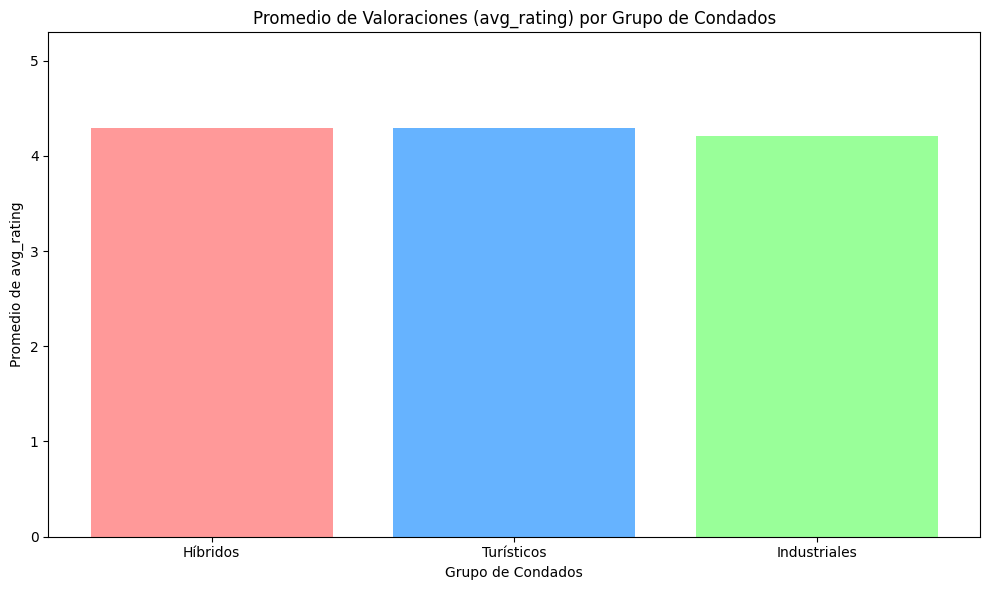

In [29]:
import matplotlib.pyplot as plt

# Crear el DataFrame con los promedios (ya calculado en el paso anterior)
df_promedios = pd.DataFrame({
    'Grupo de Condados': ['Híbridos', 'Turísticos', 'Industriales'],
    'Promedio avg_rating': [promedio_hibridos, promedio_turisticos, promedio_industriales]
})

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(df_promedios['Grupo de Condados'], df_promedios['Promedio avg_rating'], color=['#ff9999', '#66b3ff', '#99ff99'])

# Configuración del gráfico
plt.title('Promedio de Valoraciones (avg_rating) por Grupo de Condados')
plt.xlabel('Grupo de Condados')
plt.ylabel('Promedio de avg_rating')
plt.ylim(0, df_promedios['Promedio avg_rating'].max() + 1)  # Ajustar el límite superior del eje Y
plt.tight_layout()

# Mostrar el gráfico
plt.show()


El promedio general de valoraciones se encuentra entre los 4 y 5 puntos (sobre 5), lo que da una primera percepción de las reseñas: los usuarios suelen valorar los establecimientos en casos de satisfacción o experiencias positivas, con más frecuencia de las valoraciones con experiencias negativas.

**Condados Industriales o Tecnológicos**

In [33]:
# Filtrar los datos para los condados industriales
df_industriales = df_metadatos[df_metadatos['county'].isin(condados_industriales)].copy()

# Crear una columna para las categorías
def categorizar(row):
    for categoria, palabras in palabras_clave_agrupadas.items():
        if any(palabra in row['category'].lower() for palabra in palabras):
            return categoria
    return 'Otros'  # Para categorías que no coinciden

# Aplicar la función de categorización usando loc
df_industriales.loc[:, 'categoria'] = df_industriales.apply(categorizar, axis=1)

# Calcular las estadísticas
estadisticas = df_industriales.groupby('categoria')['avg_rating'].describe()
conteo_reseñas = df_industriales.groupby('categoria')['gmap_id'].count().rename("conteo_reseñas")

# Unir las estadísticas y el conteo de reseñas
resultados_finales = estadisticas[['mean', 'min', 'max', 'count']].join(conteo_reseñas)

# Verificar las columnas antes de renombrar
print(resultados_finales.columns)

# Ajustar el nombre de las columnas (agregar el conteo)
resultados_finales.columns = ['Promedio', 'Mínimo', 'Máximo', 'Conteo de Reseñas', 'Conteo de Reseñas']

# Mostrar resultados
print(resultados_finales)




Index(['mean', 'min', 'max', 'count', 'conteo_reseñas'], dtype='object')
                        Promedio  Mínimo  Máximo  Conteo de Reseñas  \
categoria                                                             
Café y bebidas          4.251397     2.9     5.0              179.0   
Comida americana        4.153448     2.5     4.8               58.0   
Comida asiática         4.146746     2.5     4.9              169.0   
Comida centroamericana  4.243363     3.0     4.9              113.0   
Comida italiana         4.218919     2.7     4.8               37.0   
Comida saludable        4.295122     3.2     5.0               41.0   
Desayuno/Brunch         4.340000     3.9     4.9               10.0   
Hamburguesas            4.243750     3.6     4.7               16.0   
Otros                   4.305631     2.6     5.0              444.0   
Pizza                   4.118519     2.6     4.8               54.0   
Sandwiches              3.918954     2.4     4.9              153.0   

   

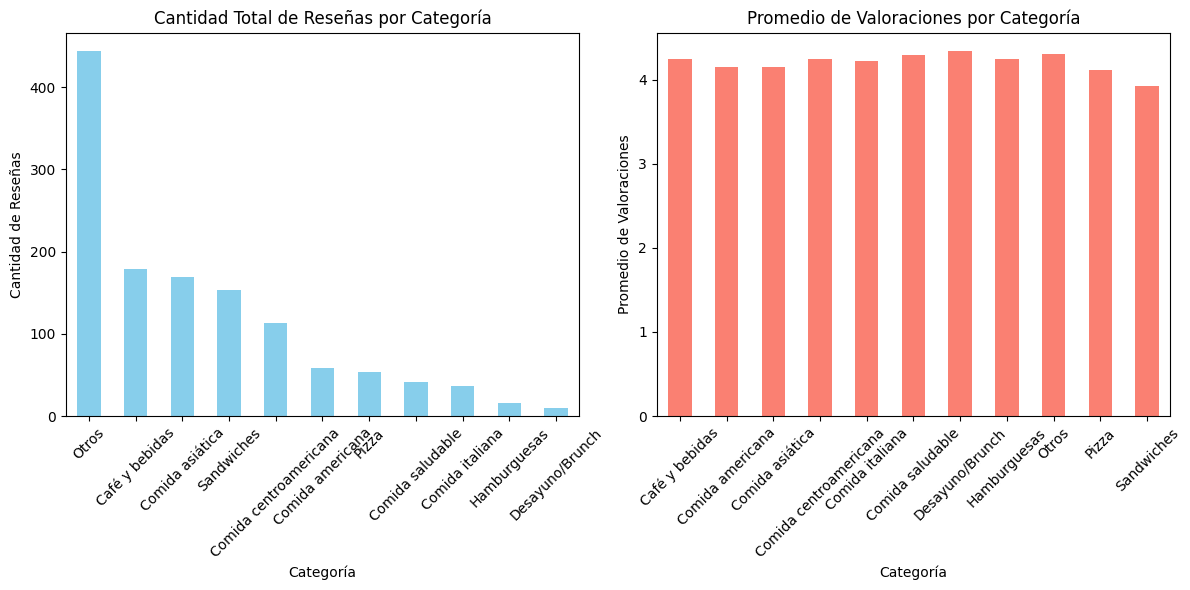

In [34]:
import matplotlib.pyplot as plt

# Gráfico de la cantidad total de reseñas por categoría
plt.figure(figsize=(12, 6))

# Contar la cantidad de reseñas por categoría
conteo_reseñas = df_industriales['categoria'].value_counts()

plt.subplot(1, 2, 1)
conteo_reseñas.plot(kind='bar', color='skyblue')
plt.title('Cantidad Total de Reseñas por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=45)
plt.tight_layout()

# Gráfico del promedio de reseñas por categoría
plt.subplot(1, 2, 2)
resultados_finales['Promedio'].plot(kind='bar', color='salmon')
plt.title('Promedio de Valoraciones por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Promedio de Valoraciones')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar los gráficos
plt.show()


Podemos observar que hay gran cantidfad de reseñas para cafés, comida asiática y sandwichs. En cuando al promedio, el mismo se mantiene en parámetros medio-altos, a excepción de la categoría "sandwichs", que está por debajo de 4 puntos, con una reseña mínima de un establecimiento de 2.4 (promedio).
Esto no dice que el rubro de sandwichs tiene establecimientos de diferente calidad. Ciertamente, 153 establecimientos de ese rubro en este grupo de condados, parece ser un exceso de oferta, que los consumidores pueden identificar como una baja de calidad, ya que al tener tanta oferta optan por aquellos que tienen mejor calidad, y suben sus pretensiones sobre ese tipo de rubro.

**Revisemos por dentro la columna "Otros"**

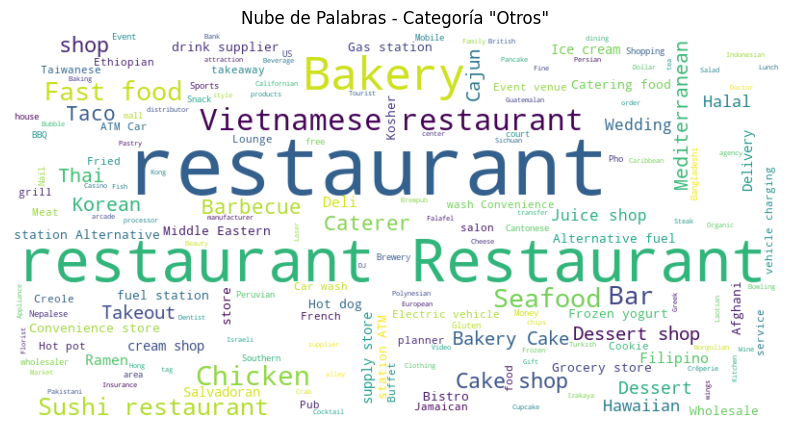

In [35]:
# Filtrar los datos para los condados industriales
df_industriales = df_metadatos[df_metadatos['county'].isin(condados_industriales)].copy()

# Crear una columna para las categorías
def categorizar(row):
    for categoria, palabras in palabras_clave_agrupadas.items():
        if any(palabra in row['category'].lower() for palabra in palabras):
            return categoria
    return 'Otros'  # Para categorías que no coinciden

# Aplicar la función de categorización
df_industriales['categoria'] = df_industriales.apply(categorizar, axis=1)

# Filtrar las filas que están en la categoría 'Otros'
df_otros = df_industriales[df_industriales['categoria'] == 'Otros']

# Concatenar todas las categorías de 'category' en un solo texto
texto_otros = ' '.join(df_otros['category'].dropna().tolist())

# Generar la nube de palabras
nube_palabras = WordCloud(width=800, height=400, background_color='white').generate(texto_otros)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras - Categoría "Otros"')
plt.show()

Por lo que vemos, no nos aporta gran relevancia, ya que en su mayoría se trata de la palabra 'restaurant'. Se avizoran algunos tipos de comida asiática que fue dejada de lado, y surge "Fast Food" como otra subcategoría.
En definitiva, podemos decir que la mayor cantidad de reseñas son de aquellos establecimientos con la categoría "Restaurant."

**Condados Turísticos**

In [52]:
# Filtrar los datos para los condados híbridos
condados_hibridos = ['Los Ángeles', 'San Francisco', 'Orange', 'San Diego']
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)].copy()

# Crear una columna para las categorías
def categorizar(row):
    # Verifica que row['category'] sea un valor único
    if isinstance(row['category'], str):
        for categoria, palabras in palabras_clave_agrupadas.items():
            if any(palabra in row['category'].lower() for palabra in palabras):
                return categoria
    return 'Otros'  # Para categorías que no coinciden

# Aplicar la función de categorización
df_hibridos['categoria'] = df_hibridos.apply(categorizar, axis=1)

# Calcular las estadísticas
estadisticas_hibridos = df_hibridos.groupby('categoria')['avg_rating'].describe()
conteo_reseñas_hibridos = df_hibridos.groupby('categoria')['gmap_id'].count().rename("conteo_reseñas")

# Unir las estadísticas y el conteo de reseñas
resultados_finales_hibridos = estadisticas_hibridos[['mean', 'min', 'max', 'count']].join(conteo_reseñas_hibridos)

# Ajustar el nombre de las columnas
resultados_finales_hibridos.columns = ['Promedio', 'Mínimo', 'Máximo', 'Conteo de Reseñas', 'Conteo de Reseñas']

# Mostrar resultados
print(resultados_finales_hibridos)


Empty DataFrame
Columns: [Promedio, Mínimo, Máximo, Conteo de Reseñas, Conteo de Reseñas]
Index: []


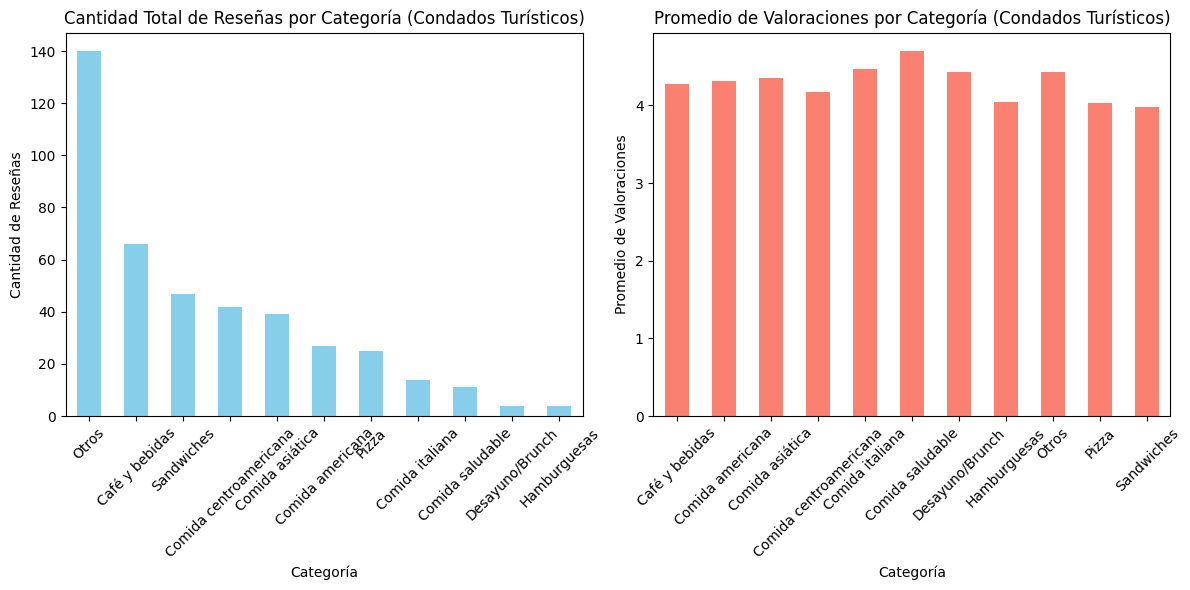

In [38]:
# Gráfico de la cantidad total de reseñas por categoría
plt.figure(figsize=(12, 6))

# Contar la cantidad de reseñas por categoría
conteo_reseñas_turisticos = df_turisticos['categoria'].value_counts()

plt.subplot(1, 2, 1)
conteo_reseñas_turisticos.plot(kind='bar', color='skyblue')
plt.title('Cantidad Total de Reseñas por Categoría (Condados Turísticos)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=45)
plt.tight_layout()

# Gráfico del promedio de reseñas por categoría
plt.subplot(1, 2, 2)
resultados_finales_turisticos['Promedio'].plot(kind='bar', color='salmon')
plt.title('Promedio de Valoraciones por Categoría (Condados Turísticos)')
plt.xlabel('Categoría')
plt.ylabel('Promedio de Valoraciones')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Para comprender mejor la diferencia, es que analizamos los mismos grupos de comida. Sin embargo, ya hemos observado ut supra la clara preponderancia de comidas rápidas.
El promedio de calificaciones sube levemente en estos sectores turísticos, y en cuanto a la cantidad, baja la popularidad de la comida saludable y de comida asiática, italiana y otras. No así con la comida centroamericana (como la mexicana), que tiene una alta tasa de reseñas.
Veamos la nube de palabras de "Otros".

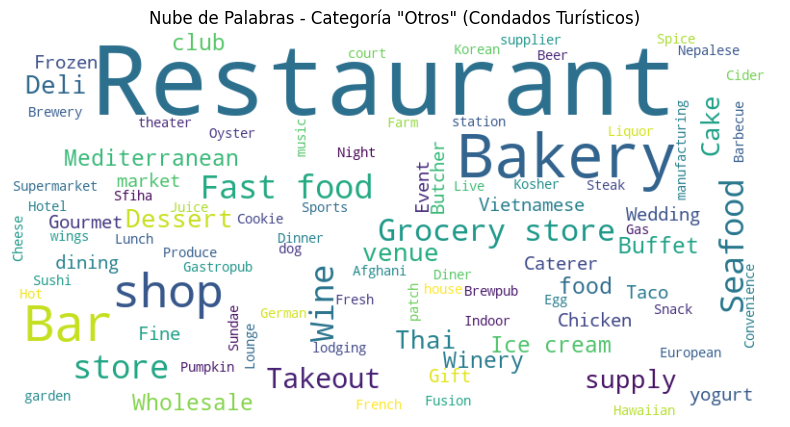

In [39]:
# Filtrar los datos para los condados turísticos
df_turisticos = df_metadatos[df_metadatos['county'].isin(condados_turisticos)].copy()

# Crear una columna para las categorías
def categorizar(row):
    for categoria, palabras in palabras_clave_agrupadas.items():
        if any(palabra in row['category'].lower() for palabra in palabras):
            return categoria
    return 'Otros'  # Para categorías que no coinciden

# Aplicar la función de categorización
df_turisticos['categoria'] = df_turisticos.apply(categorizar, axis=1)

# Filtrar las filas que están en la categoría 'Otros'
df_otros_turisticos = df_turisticos[df_turisticos['categoria'] == 'Otros']

# Concatenar todas las categorías de 'category' en un solo texto
texto_otros_turisticos = ' '.join(df_otros_turisticos['category'].dropna().tolist())

# Generar la nube de palabras
nube_palabras_turisticos = WordCloud(width=800, height=400, background_color='white').generate(texto_otros_turisticos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras_turisticos, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras - Categoría "Otros" (Condados Turísticos)')
plt.show()

Podemos pensar rápidamente en la rutina de consumo de los turistas para explicar la popularidad de palabras como 'Club', 'Night', 'Pub', 'Bar', 'Winery', 'Wine', 'Liquor', 'Beer' y otros. También confirmamos, una vez más, una fuerte presencia de fast food, **seafood**, y algunas otras del rubro "Placeres Culpables": Frozen yogurt, cookies, bakery, steak, snack, ice cream, entre muchas otras.

**Condados 'Híbridos'**

In [ ]:
df_metadatos

In [ ]:
# Filtrar los datos para los condados híbridos
condados_hibridos = ['los angeles', 'san francisco', 'orange', 'san diego']


# Asegurarte de que los nombres de condados estén en minúsculas
df_metadatos['county'] = df_metadatos['county'].str.lower()

# Filtrar los datos
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)].copy()

df_hibridos

In [66]:
# Crear una columna para las categorías
def categorizar(row):
    # Convertir la categoría a minúsculas para facilitar la comparación
    categoria_actual = row['category'].lower() if isinstance(row['category'], str) else ""
    
    for categoria, palabras in palabras_clave_agrupadas.items():
        if any(palabra in categoria_actual for palabra in palabras):
            return categoria
    return 'Otros'  # Para categorías que no coinciden

# Aplicar la función de categorización
df_hibridos['categoria'] = df_hibridos.apply(categorizar, axis=1)

# Verificar las categorías generadas
print("Categorías generadas:")
print(df_hibridos['categoria'].value_counts())

# Calcular las estadísticas
estadisticas_hibridos = df_hibridos.groupby('categoria')['avg_rating'].describe()
conteo_reseñas_hibridos = df_hibridos.groupby('categoria')['gmap_id'].count().rename("conteo_reseñas")

# Unir las estadísticas y el conteo de reseñas
resultados_finales_hibridos = estadisticas_hibridos[['mean', 'min', 'max', 'count']].join(conteo_reseñas_hibridos)

# Ajustar el nombre de las columnas
resultados_finales_hibridos.columns = ['Promedio', 'Mínimo', 'Máximo', 'Conteo de Reseñas', 'Conteo de Reseñas']

# Mostrar resultados
print(resultados_finales_hibridos)

Categorías generadas:
categoria
Otros                     1549
Café y bebidas             546
Comida centroamericana     455
Comida asiática            411
Sandwiches                 304
Comida americana           200
Pizza                      159
Comida saludable           114
Comida italiana            110
Hamburguesas                52
Desayuno/Brunch             40
Name: count, dtype: int64
                        Promedio  Mínimo  Máximo  Conteo de Reseñas  \
categoria                                                             
Café y bebidas          4.367582     3.0     5.0              546.0   
Comida americana        4.261000     2.8     4.9              200.0   
Comida asiática         4.242092     2.9     4.9              411.0   
Comida centroamericana  4.309011     3.1     4.9              455.0   
Comida italiana         4.412727     3.6     5.0              110.0   
Comida saludable        4.385088     3.3     4.9              114.0   
Desayuno/Brunch         4.437500 

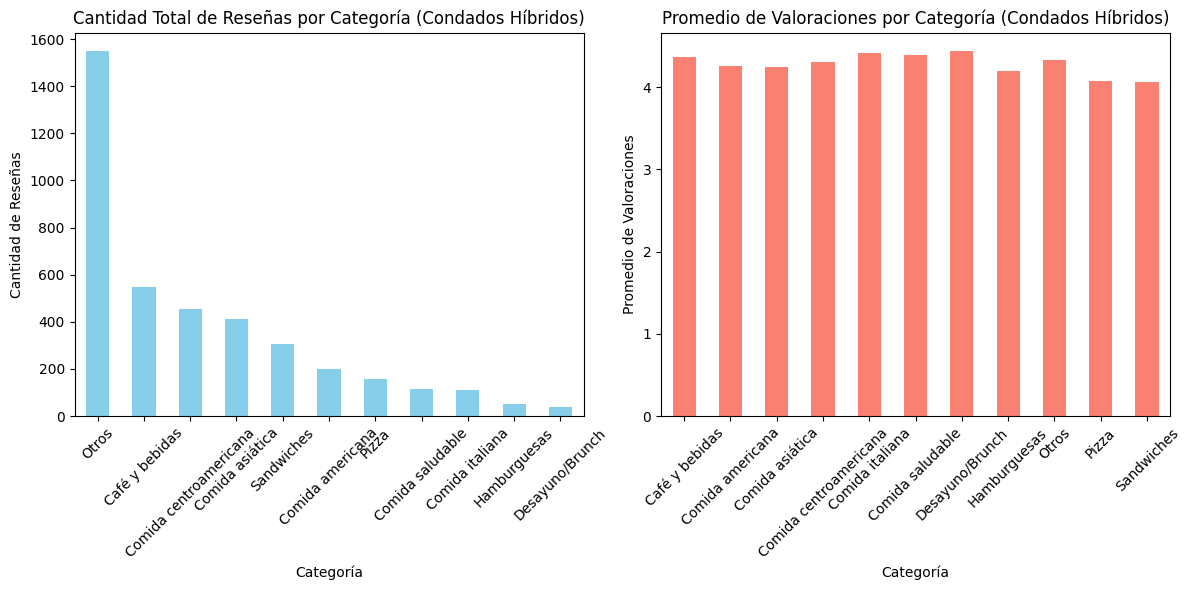

In [67]:
# Gráfico de la cantidad total de reseñas por categoría
plt.figure(figsize=(12, 6))

# Contar la cantidad de reseñas por categoría
conteo_reseñas_hibridos = df_hibridos['categoria'].value_counts()

plt.subplot(1, 2, 1)
conteo_reseñas_hibridos.plot(kind='bar', color='skyblue')
plt.title('Cantidad Total de Reseñas por Categoría (Condados Híbridos)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=45)
plt.tight_layout()

# Gráfico del promedio de reseñas por categoría
plt.subplot(1, 2, 2)
resultados_finales_hibridos['Promedio'].plot(kind='bar', color='salmon')
plt.title('Promedio de Valoraciones por Categoría (Condados Híbridos)')
plt.xlabel('Categoría')
plt.ylabel('Promedio de Valoraciones')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar los gráficos
plt.show()

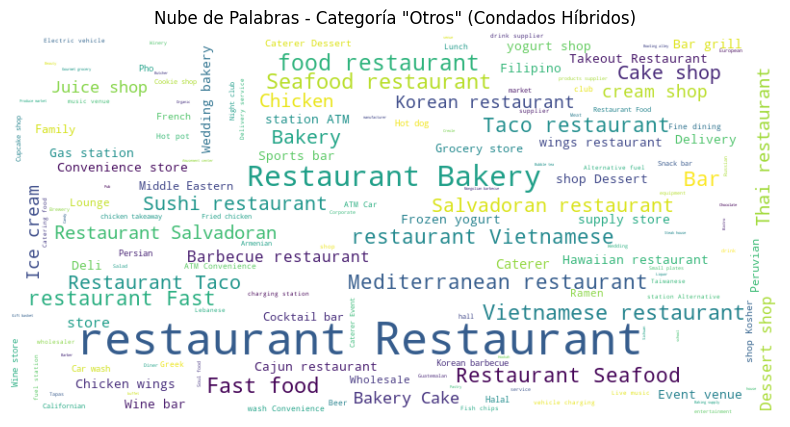

In [68]:
# Filtrar los datos para los condados híbridos
df_hibridos = df_metadatos[df_metadatos['county'].isin(condados_hibridos)].copy()

# Crear una columna para las categorías
def categorizar(row):
    for categoria, palabras in palabras_clave_agrupadas.items():
        if any(palabra in row['category'].lower() for palabra in palabras):
            return categoria
    return 'Otros'  # Para categorías que no coinciden

# Aplicar la función de categorización
df_hibridos['categoria'] = df_hibridos.apply(categorizar, axis=1)

# Filtrar las filas que están en la categoría 'Otros'
df_otros_hibridos = df_hibridos[df_hibridos['categoria'] == 'Otros']

# Concatenar todas las categorías de 'category' en un solo texto
texto_otros_hibridos = ' '.join(df_otros_hibridos['category'].dropna().tolist())

# Generar la nube de palabras
nube_palabras_hibridos = WordCloud(width=800, height=400, background_color='white').generate(texto_otros_hibridos)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras_hibridos, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.title('Nube de Palabras - Categoría "Otros" (Condados Híbridos)')
plt.show()


Para concluir con este análisis sectorizado de las reseñas, podemos notar un equilibrio entre las preferencias de los sectores tech y los sectores turísticos. Sin embargo, en éstas áreas en particular se oberva mayor consumo de comida de mar (seafood), incluso respecto a los condados exclusivamente turísticos (lo que se explica a partir de la popularidad de estos condados, y la cantidad de habitantes).
Por lo demás, el espectro de preferencias en los Condados que hemos denominado "híbridos" (por contar con atractivos turísticos y, a la vez, un gran desarrollo empresarial) es considerablemente amplio, atrayendo las preferencias de la mayoría de los condados.
Es cierto, y no puede escapar al análisis, que los condados híbridos son Los Ángeles (10,14 millones de habitantes), San Francisco (883.305 habitantes), Orange (3,17 millones de habitantes) y San Diego (1,42 millones de habitantes), y representan prácticamente el 39,4% de la población total del Estado de California.
Ello los convierte en zonas de especial interés, sobre todo porque de nuestro análisis surge una gran receptividad para todo tipo de emprendimientos. Aunque, por supuesto, algunos tienen mejores posibilidades económicas que otros.

## Análisis de Reseñas históricas

Ya hemos analizado y obtenido conclusiones contundentes al analizar los metadatos de nuestro conjunto de datos. Corresponde ahora analizar el conjunto histórico de reseñas obtenidas en esos establecimientos gastronómicos. Además de darnos información sobre los sentimientos de los consumidores, nos permitirá analizar la evolución de la recepción de ciertos establecimientos, rubros o categorías.

In [73]:
df_reviews = pd.read_parquet(r'C:\Users\GASTON\Desktop\PROYECTO FINAL\DATA\reviews_google.parquet')
df_reviews.head(3)

review_id       user_id         name       time  rating  \
0          1  1.089912e+20      Song Ro 2021-06-01       5   
1          2  1.112903e+20  Rafa Robles 2021-09-02       5   
2          3  1.126404e+20    David Han 2020-08-03       4   

                                               text  \
0                      Love there korean rice cake.   
1                                    Good very good   
2  They make Korean traditional food very properly.   

                                 gmap_id  
0  0x80c2c778e3b73d33:0xbdc58662a4a97d49  
1  0x80c2c778e3b73d33:0xbdc58662a4a97d49  
2  0x80c2c778e3b73d33:0xbdc58662a4a97d49